# Datasets (Sentiment) - Yelp - Per Side

## Yelp

- https://www.yelp.com/dataset/documentation/main
- https://www.yelp.com/developers/documentation/v3/all_category_list

In [ ]:
! wget -O data/sentiment/yelp/all_category_list.json https://www.yelp.com/developers/documentation/v3/all_category_list/categories.json

In [ ]:
#! pip install jsonlines

In [ ]:
#! pip install syntok

/disk1/users/ekoerner/miniconda3/envs/argmining19-ssc/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[]

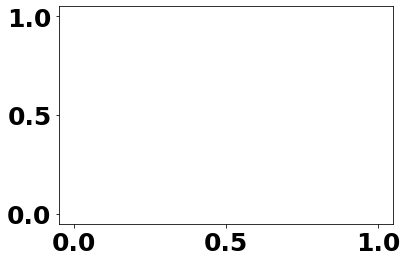

In [1]:
import json
import os
import random
import pickle
from collections import Counter
from copy import deepcopy
from itertools import combinations, groupby
from pathlib import Path
from pprint import pprint

import jsonlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.spatial.distance as ssd
from IPython.display import set_matplotlib_formats
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from syntok.tokenizer import Tokenizer
from tqdm import tqdm

tqdm.pandas()

%matplotlib inline
plt.rcParams.update({"font.size": 25, "font.weight": "bold"})
# https://stackoverflow.com/questions/36622237/jupyter-notebook-inline-plots-as-svg
# set_matplotlib_formats("svg")  # glitches it
plt.plot()

In [2]:
from utils_data import init_random
init_random()

In [3]:
# download + scp to cuda + extract
# Path on CUDA2
data_yelp_path = Path("/disk1/users/ekoerner/argmining19-same-side-classification/data/sentiment/yelp/")
# CUDA1?
#data_yelp_path = Path("/disk1/users/ekoerner/same-side-classification/argmining19-same-side-classification/data/sentiment/yelp/")

---

#### Load reviews / categories (topics) + filter cats/make combinations

In [4]:
def load_reviews(fn_yelp_reviews):
    """Load Yelp reviews. Return a Pandas dataframe.
    Format: {"id": business_id, "rid": review_id, "text": text, "rating": rating}
    And add goodness bool (rating > 3)."""
    data = list()

    with jsonlines.open(fn_yelp_reviews, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            # print(entry)
            # break
            business_id = entry.pop("business_id")
            review_id = entry.pop("review_id")
            text = entry.pop("text", "")
            rating = entry.pop("stars", 0.0)
            data.append({"id": business_id, "rid": review_id, "text": text, "rating": rating})
            # TESTING
            # if n > 10000:
            #     break

    df = pd.DataFrame.from_dict(data)
    
    # Add goodness value
    # TODO: maybe ignore with 3
    df["goodness"] = df["rating"] > 3
    
    return df


def load_topics(fn_yelp_topics, bids_not_cats=None, filter_cats=None, filter_cat_combis=None):
    """Load topics (categories).
    Optionally filter by giving it a whitelist of allowed categories.
    Optionally filter by giving a list of allowed category combinations.
    Optionally provide an IN/OUT param ``bids_not_cats`` that accumulates business ids without categories."""
    inv_bid_cats = dict()
    if bids_not_cats is None or not isinstance(bids_not_cats, set):
        bids_not_cats = set()
    
    # load lookup business -> categories
    with jsonlines.open(fn_yelp_topics, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            business_id = entry.pop("business_id")
            categories = entry.pop("categories")

            if not categories:
                bids_not_cats.add(business_id)
                continue

            categories = categories.split(", ")
            
            if filter_cats:
                categories = [c for c in categories if c in filter_cats]
                if not categories:
                    # bids_not_cats.add(business_id)  # ??
                    continue
                    
            if filter_cat_combis:
                # skip if combination is not above threshold (of filter list)
                if tuple(sorted(set(categories))) not in filter_cat_combis:
                    continue

            inv_bid_cats[business_id] = categories
    
    return inv_bid_cats

In [5]:
def filter_min_cat_combis(inv_cat_combis, min_num=30):
    """Filter category combinations by minimum amount of occurrences in businesses"""
    f_inv_cat_combis = dict()
    
    for cats, num in inv_cat_combis.items():
        if num >= min_num:
            f_inv_cat_combis[cats] = num
    
    return f_inv_cat_combis


def make_map_cats(inv_bid_cats):
    """Make a map from category to business id"""
    inv_cat_bids = dict()

    # reverse lookup: category -> businesses
    for bid, cats in tqdm(inv_bid_cats.items()):
        for cat in cats:
            try:
                inv_cat_bids[cat].append(bid)
            except KeyError:
                inv_cat_bids[cat] = [bid]
                
    ## TODO: make distinct?
    for cat in inv_cat_bids.keys():
        inv_cat_bids[cat] = list(set(inv_cat_bids[cat]))
                
    return inv_cat_bids


def make_cat_combis(inv_bid_cats):
    """Count amount of each category combination occurring in businesses"""
    inv_cat_combis = Counter()

    inv_cat_combis.update(
        (tuple(sorted(set(cats))) for cats in tqdm(inv_bid_cats.values())))
    
    return inv_cat_combis

#### Filter reviews according to criteria

In [6]:
def filter_min_review_freq(df, min_ratings=5):
    """Filter review dataframe for a minimum of N of each good and bad ratings."""
    # filter with at least N ratings per goodness
    df_filter = df.groupby(["id", "goodness"])[["id"]].count() < min_ratings
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # build a filter id list
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[~df.id.isin(df_filter_list)]
    
    return df_filtered


def filter_both_good_bad(df):
    """Filter the dataframe to contain only both good and bad reviews for each business.
    Dataframe should be the same if minimum filtering above is done."""
    # build filter for ids that contain both positive and negative samples
    df_filter = df.groupby(["id", "goodness"], as_index=False).count().groupby("id")[["id"]].count() == 2
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # create list of IDs for which this is true
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[df.id.isin(df_filter_list)]

    # df_filtered.groupby(["id", "goodness"]).count()
    return df_filtered

In [7]:
def filter_by_businesses(df, lst_business_ids):
    # filter with list, keep businesses in list
    df_filtered = df[df.id.isin(set(lst_business_ids))]

    return df_filtered


def filter_by_businesses_not_same(df, lst_business_ids):
    # filter with list, keep businesses that are not in list
    df_filtered = df[~df.id.isin(set(lst_business_ids))]

    return df_filtered

#### Get topN categories + make Ntuples from category combinations

In [8]:
def get_Ntop_cats(inv_cat_bids, n=50):
    # get most common cats
    f_cat_cnt = Counter({k: len(v) for k, v in inv_cat_bids.items()})
    f_cats = {c for c, v in f_cat_cnt.most_common(n)}
    return f_cats


def make_cat_Ntuples(f_inv_cat_combis, n=2):
    f_cat_pairs = Counter()

    for cat_group in tqdm(f_inv_cat_combis.keys()):
        if len(cat_group) < n:
            continue
        it = combinations(cat_group, n)
        # repeat (#num_businesses) + chain combis
        f_cat_pairs.update(it)
        
    return f_cat_pairs

#### Make category graph or NxN map (df + array)

In [9]:
def make_graph(f_cat_pairs):
    g_from, g_to, g_value = zip(*((k1, k2, n) for (k1, k2), n in tqdm(f_cat_pairs.most_common())))

    g_df = pd.DataFrame({"from": g_from, "to": g_to, "value": g_value})
    G = nx.from_pandas_edgelist(g_df, "from", "to", create_using=nx.Graph())
    
    return G


def make_NxN_map(f_cats, f_cat_pairs):
    f_cats = list(f_cats)
    array = list()
    for i, cat1 in enumerate(tqdm(f_cats)):
        array_row = list()
        for j, cat2 in enumerate(f_cats):
            array_row.append(f_cat_pairs.get((cat1, cat2), f_cat_pairs.get((cat2, cat1), 0)))
        array.append(array_row)
    df_cm = pd.DataFrame(array, index=list(f_cats), columns=list(f_cats))
    
    # dataframe, NxN array + labels
    return df_cm, array, f_cats

---

#### Load categories hierarchy

In [10]:
def load_category_tree(fn_all_category_list):
    with open(fn_all_category_list, "r") as fp:
        content = fp.read()
        data = json.loads(content)

    map_categories = dict()
    map_cat_name2id = dict()
    lst_root_categories = list()

    # load basic lookups
    for item in data:
        # .alias (id)
        map_categories[item["alias"]] = item
        # .title
        map_cat_name2id[item["title"]] = item["alias"]
        # .parents
        # some have multiple parents ...
        if not item["parents"]:
            lst_root_categories.append(item["alias"])
        # add list of children
        item["children"] = list()

    # add children
    for cid, item in map_categories.items():
        for parent_cid in item["parents"]:
            map_categories[parent_cid]["children"].append(item["alias"])

    return map_categories, map_cat_name2id, lst_root_categories


def get_root_category_items(map_categories):
    lst_root_categories = list()

    for cid, item in map_categories.items():
        if not item["parents"]:
            lst_root_categories.append(item)
            
    return lst_root_categories


def get_children_category_item_list(map_categories, parent_cid):
    return [
        map_categories[child_cid]
        for child_cid in map_categories[parent_cid]["children"]
    ]

##### Get businesses in categories

In [11]:
def get_businesses_in_category(inv_cat_bids, category):
    try:
        return list(set(inv_cat_bids[category]))
    except KeyError:
        return []
    
    
def get_businesses_in_category_branch(inv_cat_bids, category, map_categories, map_cat_name2id):
    map_cat_id2name = {cid: name for name, cid in map_cat_name2id.items()}

    def _get_recursive_businesses(cat_name):
        businesses = get_businesses_in_category(inv_cat_bids, cat_name)

        cid = map_cat_name2id[cat_name]
        for child_cid in map_categories[cid]["children"]:
            child_name = map_cat_id2name[child_cid]
            businesses.extend(_get_recursive_businesses(child_name))
        
        return businesses
    
    return _get_recursive_businesses(category)

##### Print category trees

In [12]:
def print_category_tree(map_categories):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            if level:
                print("  " * level, end="")
            print(f"""{item["title"]} [{item["alias"]}]""", end="")
            if item["children"]:
                print(f""" [#{len(item["children"])} children]""")
            else:
                print()
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
    _print_cat_list_rec(root_categories, level=0)


def print_category_tree_with_num_businesses(map_categories, inv_cat_bids):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            cur_line = " ." * 30
            parts = list()

            if level:
                parts.append("  " * level)
            parts.append(f"""{item["title"]} [{item["alias"]}]""")
            
            str_len = sum(len(part) for part in parts)
            print("".join(part for part in parts), end="")
            print(cur_line[str_len:], end="")
            
            if item["title"] not in inv_cat_bids:
                print(" No businesses associated!")
            else:
                print(f""" {len((inv_cat_bids[item["title"]])):>5d} businesses""")
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
            if level == 0:
                print()
            
    _print_cat_list_rec(root_categories, level=0)
    

def print_category_tree_with_num_businesses_rec(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            cur_line = " ." * 30
            parts = list()

            if level:
                parts.append("  " * level)
            parts.append(f"""{item["title"]} [{item["alias"]}]""")
            
            str_len = sum(len(part) for part in parts)
            print("".join(part for part in parts), end="")
            print(cur_line[str_len:], end="")
            
            businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
            businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])
            if not businesses:
                print(" No businesses associated!")
            else:
                businesses = set(businesses)
                print(f""" {len(businesses):>5d} businesses""", end="")
                if len(businesses) != len(businesses_self):
                    print(f""" (self: {len(businesses_self)})""", end="")
                print()
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
            if level == 0:
                print()
            
    _print_cat_list_rec(root_categories, level=0)
    
    
def print_category_tree_with_num_businesses_root(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    
    for item in sorted(root_categories, key=lambda x: x["title"]):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])

        businesses = set(businesses)
        print(f""" {len(businesses):>5d} businesses""", end="")
        if len(businesses) != len(businesses_self):
            print(f""" (self: {len(businesses_self)})""", end="")
        print()
        

def print_category_tree_with_num_businesses_root2(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    for item in root_categories:
        item["businesses"] = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        item["businesses_self"] = get_businesses_in_category(inv_cat_bids, item["title"])
    
    for item in sorted(root_categories, key=lambda x: len(set(x["businesses"]))):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = item["businesses"]
        businesses_self = item["businesses_self"]

        businesses = set(businesses)
        print(f""" {len(businesses):>5d} businesses""", end="")
        if len(businesses) != len(businesses_self):
            print(f""" (self: {len(businesses_self)})""", end="")
        print()

##### Make category comparisons

In [13]:
def print_2category_compare(inv_cat_bids, map_categories, map_cat_name2id, cat_name_i, cat_name_j):
    businesses_i = get_businesses_in_category_branch(inv_cat_bids, cat_name_i, map_categories, map_cat_name2id)
    businesses_j = get_businesses_in_category_branch(inv_cat_bids, cat_name_j, map_categories, map_cat_name2id)
    
    cat_name_i += ":"
    cat_name_j += ":"
    width = max(12, len(cat_name_i), len(cat_name_j))

    print(f"""{cat_name_i:<{width}} {len(set(businesses_i)):>5d}""")
    print(f"""{cat_name_j:<{width}} {len(set(businesses_j)):>5d}""")
    print(f"""Both: {"same:":>{width - 6}} {len(set(businesses_i) & set(businesses_j)):>5d}""")
    print(f"""{"total:":>{width}} {len(set(businesses_i) | set(businesses_j)):>5d}""")

In [14]:
def make_NxN_category_businesses_overlap(inv_cat_bids, map_categories, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])
    root_category_labels = [x["title"] for x in root_categories]
    
    array = list()
    for cname_i in root_category_labels:
        array_line = list()
        for cname_j in root_category_labels:
            businesses_i = get_businesses_in_category_branch(inv_cat_bids, cname_i, map_categories, map_cat_name2id)
            businesses_j = get_businesses_in_category_branch(inv_cat_bids, cname_j, map_categories, map_cat_name2id)
            businesses_i, businesses_j = set(businesses_i), set(businesses_j)
            businesses_ij_union = businesses_i | businesses_j
            businesses_ij_intersect = businesses_i & businesses_j
            num_businesses_ij = len(businesses_ij_intersect)
            #array_line.append(num_businesses_ij)
            array_line.append(len(businesses_ij_intersect) / len(businesses_ij_union))
        array.append(array_line)
    
    df_cm = pd.DataFrame(array, index=list(root_category_labels), columns=list(root_category_labels))
    
    return array, root_category_labels, df_cm

##### text length comparisons?

In [15]:
def get_reviews_for_category(df, cat_name, inv_cat_bids, map_categories, map_cat_name2id):
    businesses = get_businesses_in_category_branch(inv_cat_bids, cat_name, map_categories, map_cat_name2id)
    print(f"""{cat_name}: {len(businesses)}, uniq: {len(set(businesses))}""")
    businesses = set(businesses)

    df_businesses = filter_by_businesses(df, businesses)

    return df_businesses

##### Cache root category reviews in dataframes

In [16]:
dn_yelp_cached = data_yelp_path / "cached"


def cache_root_category_businesses_df(df, inv_cat_bids, map_categories, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])
    
    dn_yelp_cached = data_yelp_path / "cached"
    if not dn_yelp_cached.exists():
        print(f"Create cache dir: {dn_yelp_cached}")
        dn_yelp_cached.mkdir()
        
    for root_category in root_categories:
        fn_yelp_cached_root_cat_df = dn_yelp_cached / f"""{root_category["alias"]}_businesses.df.p"""
        if fn_yelp_cached_root_cat_df.exists():
            continue

        business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
        # business_ids = set(root_category["businesses"])
        print(f"""Filter category {root_category["title"]} [{root_category["alias"]}] with {len(set(business_ids))} businesses ...""")
        df_root_cat = filter_by_businesses(df, business_ids)

        # df_root_cat = get_reviews_for_category(df, cat_name, inv_cat_bids, map_categories, map_cat_name2id)

        df_root_cat.to_pickle(str(fn_yelp_cached_root_cat_df))
        
        
def load_cached_root_category_businesses_df(category_label, map_categories):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])

    for root_category in root_categories:
        if root_category["title"] == category_label:
            category_id = root_category["alias"]
            break
    else:
        print(f"No cached root category businesses found for: {category_label}")
        return None

    fn_yelp_cached_root_cat_df = dn_yelp_cached / f"{category_id}_businesses.df.p"
    if not fn_yelp_cached_root_cat_df.exists():
        return None
    
    df_root_cat = pd.read_pickle(str(fn_yelp_cached_root_cat_df))
    return df_root_cat

##### Filter other category businesses

In [17]:
def filter_root_category_businesses_uniq(category_label, inv_cat_bids, map_categories, map_cat_name2id):
    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=False)
    
    for root_category in root_categories:
        if root_category["title"] == category_label:
            # skip, do not trim self
            continue
            
        business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
        # business_ids = set(root_category["businesses"])
        print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(business_ids)} businesses) ...""")
        n_before = len(df_root_cat)
        df_root_cat = filter_by_businesses_not_same(df_root_cat, business_ids)
        n_after = len(df_root_cat)
        print(f"""Filtered {n_before - n_after} businesses (overlap with {root_category["title"]})""")
        
    return df_root_cat

In [18]:
def filter_root_category_businesses_not_other(category_label, category_label_filter, inv_cat_bids, map_categories, map_cat_name2id):
    assert category_label != category_label_filter, "do not filter on self"

    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=True)
    
    for root_category in root_categories:
        if root_category["title"] == category_label_filter:
            break
    else:
        print(f"No businesses found for {category_label_filter} -> return unchanged")
        return df_root_cat
    
    business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
    # businesses_ids = root_category["businesses"]
    print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(set(business_ids))} businesses) ...""")
    n_before = len(df_root_cat)
    df_root_cat = filter_by_businesses_not_same(df_root_cat, business_ids)
    n_after = len(df_root_cat)
    print(f"""Filtered {n_before - n_after} businesses (overlap with {root_category["title"]})""")
    
    return df_root_cat

In [19]:
def filter_root_category_businesses_same_other(category_label, category_label_filter, inv_cat_bids, map_categories, map_cat_name2id):
    assert category_label != category_label_filter, "do not filter on self"

    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=True)
    
    for root_category in root_categories:
        if root_category["title"] == category_label_filter:
            break
    else:
        print(f"No businesses found for {category_label_filter} -> return unchanged")
        return df_root_cat
    
    business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
    # businesses_ids = root_category["businesses"]
    print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(set(business_ids))} businesses) ...""")
    n_before = len(df_root_cat)
    df_same = filter_by_businesses(df_root_cat, business_ids)
    n_after = len(df_same)
    print(f"""Filtered {n_before - n_after} businesses ({n_after} same with {root_category["title"]})""")
    
    return df_same

---

#### Make Pairs

**TODO:**

- check similar length -- what strategy to use to combine similar length pairs best?
- flip sides (arg1 <-> arg2)
- make more pairs (?) -- but keep same ratio of same-sentiment vs. not-same-sentiment (different-sentiment) ??
- group by categories (topics) -- more explicit training (uniqueness of single arguments / topic structures)
- evaluate on same-argument (S3C) - or amazon reviews
- compute mean/avg sequence length
- fixed layers in fine-tuning
- visualization of trained layers and activation for good / bad inputs

##### Positive + negative same-sentiment pairs

In [20]:
num_pairs_per_class = 2
# N positive + N negative
# --> 2N pos+neg (not same-sentiment)

# TODO: randomness for positive ss / negative ss - sum is equal / or sum equal compared to not ss

In [21]:
def make_pairs_good_bad(df, num_pairs_per_class=2):
    pairs_good = list()
    pairs_bad = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # TESTING
        # print("id:", id_)
        # print("#good:", len(reviews_good))
        # print("#bad:", len(reviews_bad))
        # print(group)
        # break

        # make pairings -- good ss
        rg_idx = reviews_good.index.values
        # print("pos_idx:", rg_idx)
        rg_idx_sel = np.random.choice(rg_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rg_idx_sel[::2], rg_idx_sel[1::2]):
            # print("pair:", id1, id2)
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": True, "type": "good-good",
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            # print(pair)
            pairs_good.append(pair)

        # make pairings -- bad ss
        rb_idx = reviews_bad.index.values
        # print("neg_idx:", rb_idx)
        rb_idx_sel = np.random.choice(rb_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rb_idx_sel[::2], rb_idx_sel[1::2]):
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": False, "type": "bad-bad",
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            pairs_bad.append(pair)

        # break
        
    return pairs_good, pairs_bad

##### not same-sentiment pairs (combinations positive + negative)

In [22]:
#: number of negative same-sentiment samples same as positive same-sentiment samples
num_pairs_negative = 2 * num_pairs_per_class

#: whether for a single side (good or bad) there can be multiple occurrences of the same review
#: may need to check afterwared that not by chance same pairing happens ...
repeatable_on_side = False

In [23]:
def make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False):
    pairs_not_ss = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # find indices for reviews per business
        rg_idx = reviews_good.index.values
        rb_idx = reviews_bad.index.values

        # randomly select from each side
        rg_idx_sel = np.random.choice(rg_idx, num_pairs_negative, replace=repeatable_on_side)
        rb_idx_sel = np.random.choice(rb_idx, num_pairs_negative, replace=repeatable_on_side)

        # pair them together -- good-bad pairs
        for idg, idb in zip(rg_idx_sel[::2], rb_idx_sel[::2]):
            rg, rb = df.loc[idg], df.loc[idb]
            pair = {
                "argument1": rg["text"], "argument2": rb["text"],
                "argument1_id": f"""{rg["id"]}|{rg["rid"]}""", "argument2_id": f"""{rb["id"]}|{rb["rid"]}""",
                "is_same_side": False, "is_good_side": None, "type": "good-bad",
                "topic": inv_bid_cats.get(rg["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)

        # bad-good pairs
        for idb, idg in zip(rb_idx_sel[1::2], rg_idx_sel[1::2]):
            rb, rg = df.loc[idb], df.loc[idg]
            pair = {
                "argument1": rb["text"], "argument2": rg["text"],
                "argument1_id": f"""{rb["id"]}|{rb["rid"]}""", "argument2_id": f"""{rg["id"]}|{rg["rid"]}""",
                "is_same_side": False, "is_good_side": None, "type": "bad-good",
                "topic": inv_bid_cats.get(rb["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)
            
    return pairs_not_ss

##### dataframe for training etc.

In [24]:
def make_or_load_pairs(df, fn_yelp_df, num_pairs_per_class=2):
    if fn_yelp_df is not None:
        if os.path.exists(fn_yelp_df):
            with open(fn_yelp_df, "rb") as fp:
                all_df = pickle.load(fp)
            return all_df
    
    pairs_good, pairs_bad = make_pairs_good_bad(df, num_pairs_per_class=num_pairs_per_class)
    print("#ss (pos)", len(pairs_good))
    print("#ss (neg)", len(pairs_bad))
    
    num_pairs_negative = 2 * num_pairs_per_class
    pairs_not_ss = make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False)
    print("#nss", len(pairs_not_ss))
    
    pairs_all = pairs_good + pairs_bad + pairs_not_ss
    print("#~ss", len(pairs_all))
    
    np.random.shuffle(pairs_all)
    df_traindev = pd.DataFrame.from_dict(pairs_all)
    
    if fn_yelp_df is not None:
        with open(fn_yelp_df, "wb") as fp:
            pickle.dump(df_traindev, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    return df_traindev

---

---

---

## Load reviews and topics and category tree

#### Load reviews

- review (with business reference)

In [41]:
fn_yelp_reviews = data_yelp_path / "review.json"
df = load_reviews(fn_yelp_reviews)

6685900it [00:40, 164583.01it/s]


#### Load categories for businesses

- business (id) with list of topics/categories
- lookups (business -> categories, category -> businesses)
- list of combinations (with amount)

In [42]:
fn_yelp_topics = data_yelp_path / "business.json"
bids_not_cats = set()
inv_bid_cats = load_topics(fn_yelp_topics, bids_not_cats=bids_not_cats)

inv_cat_bids = make_map_cats(inv_bid_cats)

inv_cat_combis = make_cat_combis(inv_bid_cats)

192609it [00:01, 111173.53it/s]
100%|██████████| 192127/192127 [00:00<00:00, 730872.70it/s]


#### Load category tree

- hierarchy of categories

In [43]:
fn_yelp_catgory_tree = data_yelp_path / "all_category_list.json"
map_categories, map_cat_name2id, lst_root_categories = load_category_tree(fn_yelp_catgory_tree)

#### Pre-Cache all root category businesses (reviews)

In [44]:
cache_root_category_businesses_df(df, inv_cat_bids, map_categories, map_cat_name2id)

---

---

#### dataframe for training etc.

In [29]:
fn_yelp_df = data_yelp_path / "df_traindev4_typed.p"

df = filter_min_review_freq(df, min_ratings=8)
df = filter_both_good_bad(df)

df_traindev = make_or_load_pairs(df, str(fn_yelp_df), num_pairs_per_class=4)

100%|██████████| 43985/43985 [02:22<00:00, 308.38it/s]


#ss (pos) 175940
#ss (neg) 175940


100%|██████████| 43985/43985 [02:18<00:00, 316.48it/s]


#nss 351880
#~ss 703760


In [25]:
fn_yelp_df = data_yelp_path / "df_traindev4_typed.p"

with open(fn_yelp_df, "rb") as fp:
    traindev_df = pickle.load(fp)

---

#### Reloading for training

In [ ]:
data_yelp_path = Path("/home/ekoerner/same-side-classification/data/sentiment/yelp/")
fn_yelp_df = data_yelp_path / "df_traindev.p"

with open(fn_yelp_df, "rb") as fp:
    all_df = pickle.load(fp)

In [30]:
def _add_dummy_tag(row):
    row["tag"] = "NA"
    return row

# all_df = all_df.progress_apply(_add_dummy_tag, axis=1)
all_df["tag"] = "NA"

NameError: name 'all_df' is not defined

In [ ]:
num = len(all_df)
ratio = 0.3
idx_ratio = int(num * (1.0 - ratio))
print(f"traindev: [0:{idx_ratio}], test: [{idx_ratio}:{num}], ratio: {ratio}")

traindev_df = all_df.iloc[:idx_ratio]
test_df = all_df.iloc[idx_ratio:]

In [36]:
fn_yelp_df = data_yelp_path / "df_traindev4_typed.p"

#df = filter_min_review_freq(df, min_ratings=8)
#df = filter_both_good_bad(df)

traindev_df = make_or_load_pairs(df, str(fn_yelp_df), num_pairs_per_class=4)

In [ ]:
# len(traindev_df), len(test_df)

---
---
---

## Default S3C training

https://gluon-nlp.mxnet.io/install.html

```bash
pip install --upgrade 'mxnet>=1.3.0'  
pip install gluonnlp  
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip  
unzip sentence_embedding.zip  
ln -s sentence_embedding/bert bert  
```

In [ ]:
# ! pip install --upgrade 'mxnet>=1.3.0'
# NOTE: do not install cpu + gpu version both, only one!
! pip install --upgrade mxnet-cu102
! pip install --upgrade gluonnlp 

In [ ]:
! wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
# ! unzip sentence_embedding.zip
# ! ln -s sentence_embedding/bert bert

In [26]:
from mxboard import SummaryWriter

from utils_data import get_train_test_sets

from utils_gluon import setup_bert_epi128bce, setup_bert_epi512bce
from utils_gluon import setup_bert_pro128bce, setup_bert_pro512bce

from utils_gluon import transform_dataset
from utils_gluon import predict_out_to_ys

from utils_gluon import predict
from utils_gluon import train

# from utils_gluon import print_infos
from utils_gluon import plot_train_stats

from utils_gluon import report_training_results
from utils_gluon import plot_confusion_matrix
from utils_gluon import compute_metrics

from utils_data import names_columns_X, names_columns_X_arteval, names_columns_y
# names_columns_X = ['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic', 'type']
names_columns_X = names_columns_X + ['type']

from sklearn.model_selection import train_test_split

In [27]:
from utils_data import Timer

from utils_data import configure_logging
configure_logging()

from utils_data import init_random
init_random()

In [28]:
# extracted to include "type" (of pairing)
# train dev set - 70% 30%
def get_train_test_sets(df, ratio=0.30, random_state=1):
    X = df[names_columns_X]
    y = df[names_columns_y]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=ratio,
                                                        random_state=random_state,
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

---

In [ ]:
run_name = "yelp_1_pro128BCE"
fn_run_path = Path(f"data/{run_name}")
fn_traindev_df = fn_run_path / "traindev.p"

category_name = "*"  # just a dummy ...

! mkdir data/yelp_1_pro128BCE

In [ ]:
run_name = "yelp_3_arts_pro128BCE"
fn_run_path = Path(f"data/{run_name}")
fn_traindev_df = fn_run_path / "traindev.p"

category_name = "Arts & Entertainment"

! mkdir data/yelp_3_arts_pro128BCE

In [29]:
run_name = "yelp_7_pro128BCE"
fn_run_path = Path(f"data/{run_name}")
fn_traindev_df = fn_run_path / "traindev.p"

category_name = "*"  # just a dummy ...

! mkdir data/yelp_7_pro128BCE

mkdir: cannot create directory ‘data/yelp_7_pro128BCE’: File exists


---

In [ ]:
df_food = load_cached_root_category_businesses_df(category_name, map_categories)
# df_food = get_reviews_for_category(df, category_name, inv_cat_bids, map_categories, map_cat_name2id)

df_uniq_food = filter_root_category_businesses_uniq(category_name, inv_cat_bids, map_categories, map_cat_name2id)

len(df), len(df_food), len(df_uniq_food)

In [ ]:
df_td = df_uniq_food

In [ ]:
# min ratings per class (good|bad)
min_ratings = 5

df_td = filter_min_review_freq(df_td, min_ratings=5)

In [ ]:
df_td = filter_both_good_bad(df_td)

In [ ]:
traindev_df = make_or_load_pairs(df_td, str(fn_traindev_df), num_pairs_per_class=2)

In [ ]:
len(traindev_df)  # pairs

In [30]:
# check how many pairs are per pairing
for pairtype, df_grouped in traindev_df.groupby(["type"]):
    print(pairtype, len(df_grouped))
    # df_grouped.describe()

bad-bad 175940
bad-good 175940
good-bad 175940
good-good 175940


---

In [31]:
def _add_dummy_tag(row):
    row["tag"] = "NA"
    return row

# all_df = all_df.progress_apply(_add_dummy_tag, axis=1)
traindev_df["tag"] = "NA"

In [32]:
X_train, X_dev, y_train, y_dev = get_train_test_sets(traindev_df, ratio=0.1)

In [33]:
with Timer("setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert_pro128bce(gpu=1)

Start on [setup BERT model] ...
Time for [setup BERT model]: 0:00:02.623986


In [34]:
with Timer("prepare training / validation data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)

Start on [prepare training / validation data] ...
Time for [prepare training / validation data]: 0:00:51.610836


In [35]:
num_epochs = 3
batch_size = 32

In [74]:
run_name1 = "yelp_1_pro128BCE"
fn_run_path1 = Path(f"data/{run_name1}")
epoch_id = num_epochs - 1
fn_model_state = fn_run_path1 / f"bert.model.checkpoint{epoch_id}.params"
print(f"Load {fn_model_state} ...")
model.load_parameters(str(fn_model_state), ctx=ctx)

Load data/yelp_1_pro128BCE/bert.model.checkpoint2.params ...


Confusion Matrix:
[[27379  7845]
 [ 6286 28866]]

CM: [27379  7845  6286 28866] 
[tn, fp, fn, tp]
  accuracy: 0.799
 precision: 0.800
    recall: 0.799
  f1-score: 0.799

Accuracy:  0.799 

Report for [BERTClassifier - yelp_7_pro128BCE]:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     35224
           1       0.79      0.82      0.80     35152

    accuracy                           0.80     70376
   macro avg       0.80      0.80      0.80     70376
weighted avg       0.80      0.80      0.80     70376



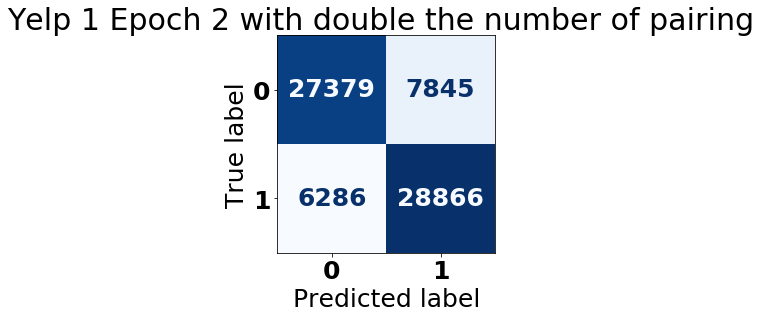

In [49]:
# for train set
print("Evaluate trained model for each epoch ...")
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
with open(fn_run_path / f"yelp_1_eval_epoch{epoch_id}.p", "wb") as fp:
    pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp 1 Epoch {epoch_id} with double the number of pairing", values_format="d", cmap="Blues", include_colorbar=False)
plt.show()

  0%|          | 1/21993 [00:00<39:23,  9.30it/s]

Evaluate trained model for each epoch ...
Start on [prediction] ...


100%|██████████| 21993/21993 [35:10<00:00, 10.42it/s]


Time for [prediction]: 0:35:10.077056
Confusion Matrix:
[[273627  78253]
 [ 61749 290131]]

CM: [273627  78253  61749 290131] 
[tn, fp, fn, tp]
  accuracy: 0.801
 precision: 0.802
    recall: 0.801
  f1-score: 0.801

Accuracy:  0.801 

Report for [BERTClassifier - yelp_7_pro128BCE (ALL)]:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80    351880
           1       0.79      0.82      0.81    351880

    accuracy                           0.80    703760
   macro avg       0.80      0.80      0.80    703760
weighted avg       0.80      0.80      0.80    703760



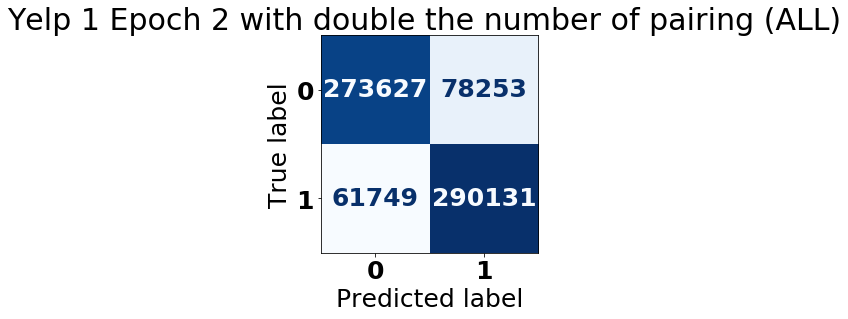

In [75]:
# for whole dataset
print("Prepare dataset ...")
X_dev, y_dev = traindev_df[names_columns_X], traindev_df[names_columns_y]
_, data_dev = transform_dataset(X_dev, y_dev, transform)

print("Evaluate trained model for each epoch ...")
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
with open(fn_run_path / f"yelp_1_eval_epoch{epoch_id}_all.p", "wb") as fp:
    pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} (ALL)", heatmap=False)
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp 1 Epoch {epoch_id} with double the number of pairing (ALL)", values_format="d", cmap="Blues", include_colorbar=False)
plt.show()

In [71]:
# merge train df
traindev2_df = X_dev.join(y_dev)

# group train df
grouped_traindev_df = {pairtype: df_grouped for pairtype, df_grouped in traindev2_df.groupby(["type"])}
for pairtype, df_grouped in grouped_traindev_df.items():
    print(pairtype, len(df_grouped))

# split train df

grouped_traindev_df = {
    pairtype: (df_grouped[names_columns_X], df_grouped[names_columns_y])
    for pairtype, df_grouped in grouped_traindev_df.items()
}

bad-bad 17611
bad-good 17631
good-bad 17593
good-good 17541


In [72]:
with Timer("prepare validation data"):
    data_dev_grouped = {
        # data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
        pairtype: transform_dataset(X_dev, y_dev, transform)
        for pairtype, (X_dev, y_dev) in grouped_traindev_df.items()
    }

Start on [prepare training / validation data] ...
Time for [prepare training / validation data]: 0:00:05.021262


  0%|          | 1/551 [00:00<01:01,  8.98it/s]

Evaluate trained model on pairtype bad-bad #7...
Start on [prediction] ...


100%|██████████| 551/551 [00:53<00:00, 10.33it/s]


Time for [prediction]: 0:00:53.344296
Confusion Matrix:
[[    0     0]
 [ 4086 13525]]

CM: [    0     0  4086 13525] 
[tn, fp, fn, tp]
  accuracy: 0.768
 precision: 0.500
    recall: 0.384
  f1-score: 0.434

Accuracy:  0.768 

Report for [BERTClassifier - yelp_7_pro128BCE - bad-bad]:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.77      0.87     17611

    accuracy                           0.77     17611
   macro avg       0.50      0.38      0.43     17611
weighted avg       1.00      0.77      0.87     17611



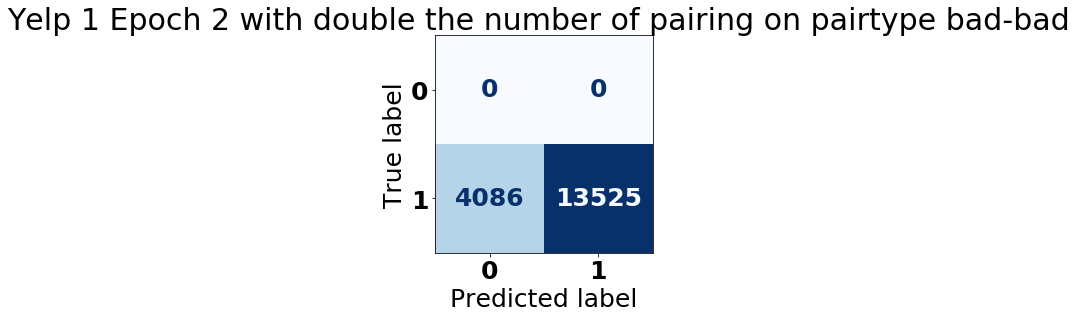

  0%|          | 0/551 [00:00<?, ?it/s]

Evaluate trained model on pairtype bad-good #8...
Start on [prediction] ...


100%|██████████| 551/551 [00:52<00:00, 10.53it/s]


Time for [prediction]: 0:00:52.332887
Confusion Matrix:
[[13637  3994]
 [    0     0]]

CM: [13637  3994     0     0] 
[tn, fp, fn, tp]
  accuracy: 0.773
 precision: 0.500
    recall: 0.387
  f1-score: 0.436

Accuracy:  0.773 

Report for [BERTClassifier - yelp_7_pro128BCE - bad-good]:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     17631
           1       0.00      0.00      0.00         0

    accuracy                           0.77     17631
   macro avg       0.50      0.39      0.44     17631
weighted avg       1.00      0.77      0.87     17631



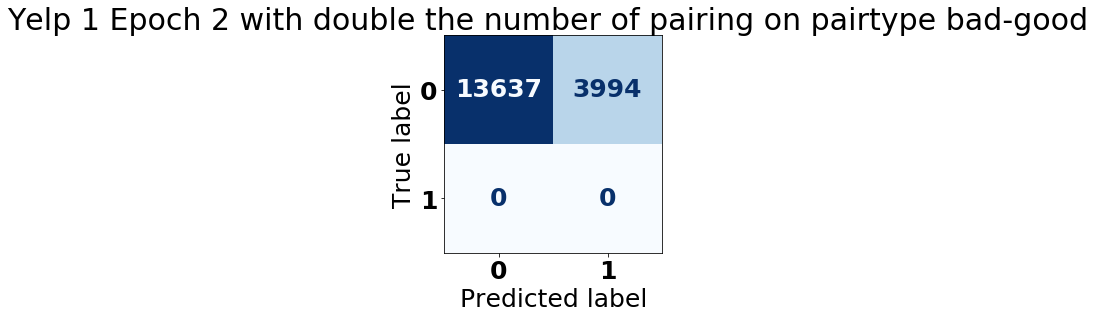

  0%|          | 0/550 [00:00<?, ?it/s]

Evaluate trained model on pairtype good-bad #8...
Start on [prediction] ...


100%|██████████| 550/550 [00:52<00:00, 10.49it/s]


Time for [prediction]: 0:00:52.435732
Confusion Matrix:
[[13742  3851]
 [    0     0]]

CM: [13742  3851     0     0] 
[tn, fp, fn, tp]
  accuracy: 0.781
 precision: 0.500
    recall: 0.391
  f1-score: 0.439

Accuracy:  0.781 

Report for [BERTClassifier - yelp_7_pro128BCE - good-bad]:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88     17593
           1       0.00      0.00      0.00         0

    accuracy                           0.78     17593
   macro avg       0.50      0.39      0.44     17593
weighted avg       1.00      0.78      0.88     17593



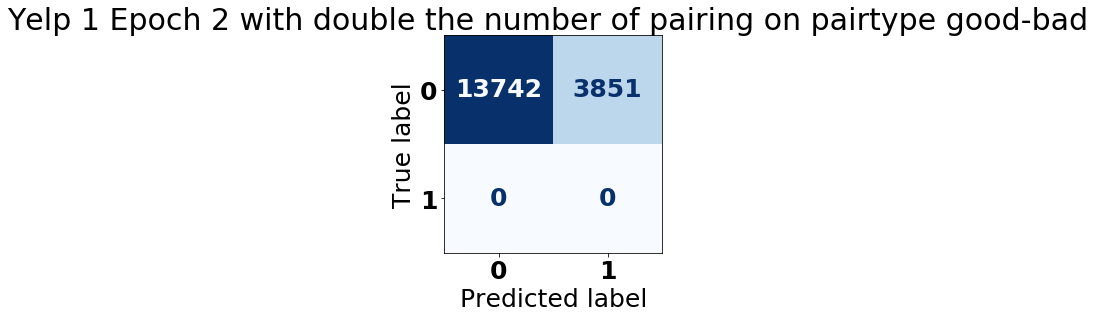

  0%|          | 0/549 [00:00<?, ?it/s]

Evaluate trained model on pairtype good-good #9...
Start on [prediction] ...


100%|██████████| 549/549 [00:50<00:00, 10.77it/s]


Time for [prediction]: 0:00:50.972915
Confusion Matrix:
[[    0     0]
 [ 2200 15341]]

CM: [    0     0  2200 15341] 
[tn, fp, fn, tp]
  accuracy: 0.875
 precision: 0.500
    recall: 0.437
  f1-score: 0.467

Accuracy:  0.875 

Report for [BERTClassifier - yelp_7_pro128BCE - good-good]:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.87      0.93     17541

    accuracy                           0.87     17541
   macro avg       0.50      0.44      0.47     17541
weighted avg       1.00      0.87      0.93     17541



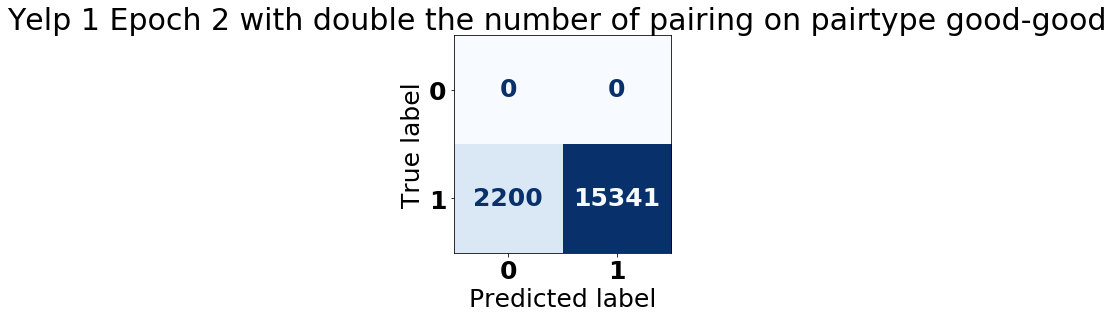

In [73]:
for pairtype, (_, data_dev) in data_dev_grouped.items():
    print(f"Evaluate trained model on pairtype {pairtype} #{len(pairtype)}...")

    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    with open(fn_run_path / f"yelp_1_eval_epoch{epoch_id}_{pairtype}.p", "wb") as fp:
        pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {pairtype}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp 1 Epoch {epoch_id} with double the number of pairing on pairtype {pairtype}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()

pair-type-wise evaluation _(on pre-trained yelp_1_* model)_

```
          [  tn,   fp,   fn,    tp]   Acc     #num
bad-bad   [    0     0  4086 13525]   0.768   17611
bad-good  [13637  3994     0     0]   0.773   17631
good-bad  [13742  3851     0     0]   0.781   17593
good-good [    0     0  2200 15341]   0.875   17541

all*      [27379  7845  6286 28866]   0.799   70376
```

---

In [76]:
# ALL traindev_df
# group train df
grouped_traindev_df = {pairtype: df_grouped for pairtype, df_grouped in traindev_df.groupby(["type"])}
for pairtype, df_grouped in grouped_traindev_df.items():
    print(pairtype, len(df_grouped))

# split train df
grouped_traindev_df = {
    pairtype: (df_grouped[names_columns_X], df_grouped[names_columns_y])
    for pairtype, df_grouped in grouped_traindev_df.items()
}

bad-bad 175940
bad-good 175940
good-bad 175940
good-good 175940


In [78]:
with Timer("prepare validation data"):
    data_dev_grouped = {
        # data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
        pairtype: transform_dataset(X_dev, y_dev, transform)[1]
        for pairtype, (X_dev, y_dev) in grouped_traindev_df.items()
    }

Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:53.107414


  0%|          | 1/5499 [00:00<10:18,  8.89it/s]

Evaluate trained model on pairtype bad-bad #7...
Start on [prediction] ...


100%|██████████| 5499/5499 [09:00<00:00, 10.18it/s]


Time for [prediction]: 0:09:00.095693
Confusion Matrix:
[[     0      0]
 [ 40575 135365]]

CM: [     0      0  40575 135365] 
[tn, fp, fn, tp]
  accuracy: 0.769
 precision: 0.500
    recall: 0.385
  f1-score: 0.435

Accuracy:  0.769 

Report for [BERTClassifier - yelp_7_pro128BCE - bad-bad]:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.77      0.87    175940

    accuracy                           0.77    175940
   macro avg       0.50      0.38      0.43    175940
weighted avg       1.00      0.77      0.87    175940



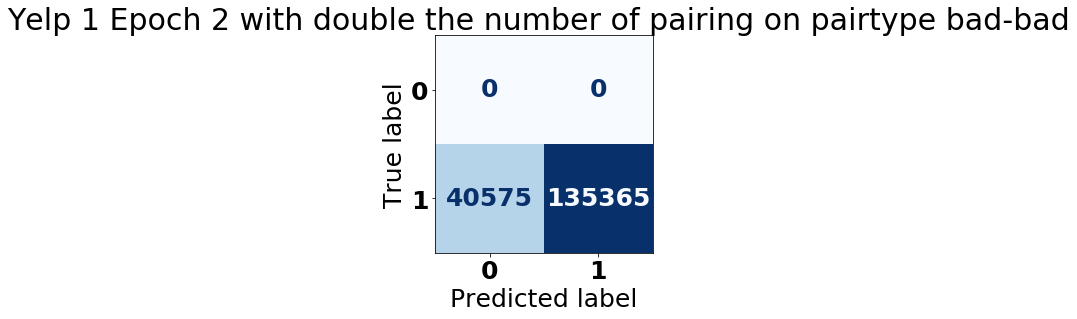

  0%|          | 2/5499 [00:00<08:40, 10.55it/s]

Evaluate trained model on pairtype bad-good #8...
Start on [prediction] ...


100%|██████████| 5499/5499 [08:47<00:00, 10.42it/s]


Time for [prediction]: 0:08:47.922924
Confusion Matrix:
[[135835  40105]
 [     0      0]]

CM: [135835  40105      0      0] 
[tn, fp, fn, tp]
  accuracy: 0.772
 precision: 0.500
    recall: 0.386
  f1-score: 0.436

Accuracy:  0.772 

Report for [BERTClassifier - yelp_7_pro128BCE - bad-good]:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87    175940
           1       0.00      0.00      0.00         0

    accuracy                           0.77    175940
   macro avg       0.50      0.39      0.44    175940
weighted avg       1.00      0.77      0.87    175940



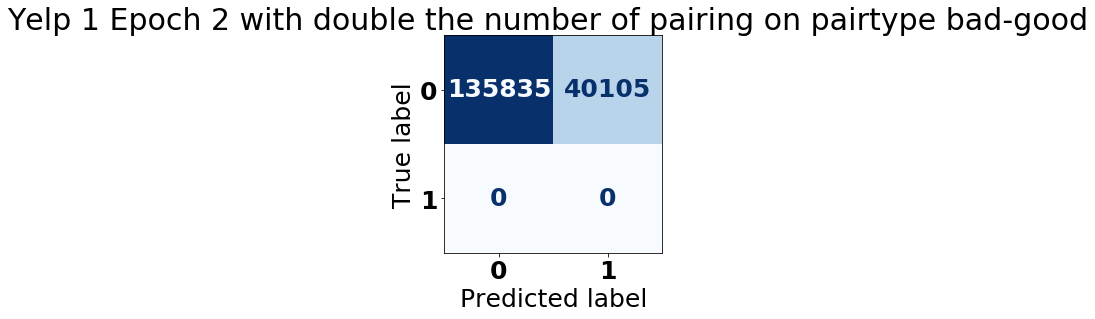

  0%|          | 2/5499 [00:00<08:49, 10.38it/s]

Evaluate trained model on pairtype good-bad #8...
Start on [prediction] ...


100%|██████████| 5499/5499 [08:47<00:00, 10.42it/s]


Time for [prediction]: 0:08:47.778116
Confusion Matrix:
[[137792  38148]
 [     0      0]]

CM: [137792  38148      0      0] 
[tn, fp, fn, tp]
  accuracy: 0.783
 precision: 0.500
    recall: 0.392
  f1-score: 0.439

Accuracy:  0.783 

Report for [BERTClassifier - yelp_7_pro128BCE - good-bad]:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88    175940
           1       0.00      0.00      0.00         0

    accuracy                           0.78    175940
   macro avg       0.50      0.39      0.44    175940
weighted avg       1.00      0.78      0.88    175940



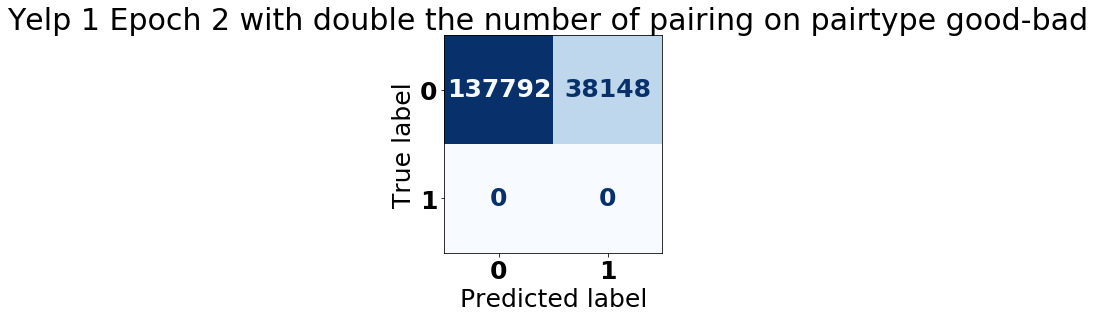

  0%|          | 2/5499 [00:00<08:31, 10.75it/s]

Evaluate trained model on pairtype good-good #9...
Start on [prediction] ...


100%|██████████| 5499/5499 [08:33<00:00, 10.70it/s]


Time for [prediction]: 0:08:33.750572
Confusion Matrix:
[[     0      0]
 [ 21174 154766]]

CM: [     0      0  21174 154766] 
[tn, fp, fn, tp]
  accuracy: 0.880
 precision: 0.500
    recall: 0.440
  f1-score: 0.468

Accuracy:  0.88 

Report for [BERTClassifier - yelp_7_pro128BCE - good-good]:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.88      0.94    175940

    accuracy                           0.88    175940
   macro avg       0.50      0.44      0.47    175940
weighted avg       1.00      0.88      0.94    175940



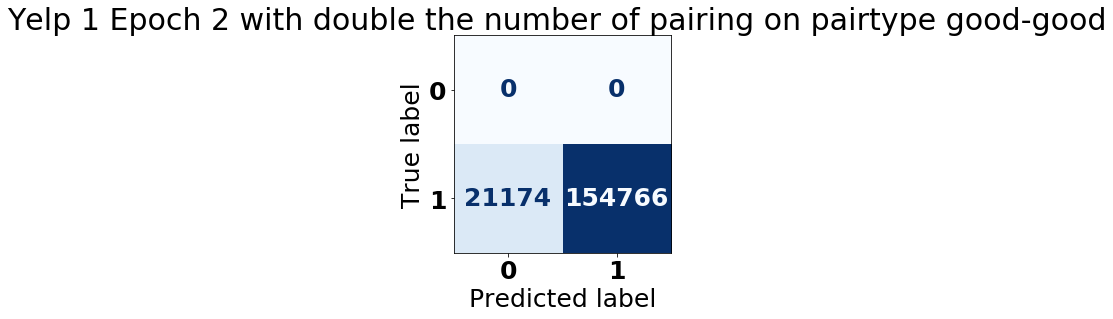

In [79]:
for pairtype, data_dev in data_dev_grouped.items():
    print(f"Evaluate trained model on pairtype {pairtype} #{len(pairtype)}...")

    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    with open(fn_run_path / f"yelp_1_eval_epoch{epoch_id}_{pairtype}.p", "wb") as fp:
        pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {pairtype}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp 1 Epoch {epoch_id} with double the number of pairing on pairtype {pairtype}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()

pair-type-wise evaluation _(on pre-trained yelp_1_* model)_

```
          [  tn,   fp,   fn,    tp]   Acc     #num
bad-bad   [    0     0  4086 13525]   0.768   17611
bad-good  [13637  3994     0     0]   0.773   17631
good-bad  [13742  3851     0     0]   0.781   17593
good-good [    0     0  2200 15341]   0.875   17541

all*      [27379  7845  6286 28866]   0.799   70376
```

pair-type-wise evaluation _(on pre-trained yelp_1* model)_ using all traindev data (4 per business)

```
          [   tn,    fp,    fn,     tp]   Acc     #num
bad-bad   [     0      0  40575 135365]   0.769   175940
bad-good  [135835  40105      0      0]   0.772   175940
good-bad  [137792  38148      0      0]   0.783   175940
good-good [     0      0  21174 154766]   0.880   175940

all*      [273627  78253  61749 290131]   0.801   703760
```

##### Training with TRAIN set

In [36]:
fn_run_path

PosixPath('data/yelp_7_pro128BCE')

In [ ]:
for epoch_id in range(num_epochs):
    with Timer(f"train model - {epoch_id}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=batch_size, lr=5e-6, num_epochs=epoch_id + 1, sw=sw, checkpoint_dir=str(fn_run_path))
        plot_train_stats(stats)

    with Timer(f"evaluate - {epoch_id}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
        print(f"Accuracy in epoch {epoch_id}:", metric.get()[1])

        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)

    model.save_parameters(str(fn_run_path / "bert.model.params"))

  0%|          | 175/633384 [00:00<06:02, 1747.21it/s]

Start on [train model - 0] ...
Start on [setup training] ...


  0%|          | 0/19799 [00:00<?, ?it/s]

Time for [setup training]: 0:05:49.774851
Start on [training] ...
Start on [epoch 0] ...


  0%|          | 1/19799 [00:00<5:24:36,  1.02it/s]2020-06-09 21:09:02,968 : INFO : successfully opened events file: data/yelp_7_pro128BCE/events.out.tfevents.1591729742.cuda2
2020-06-09 21:09:02,975 : INFO : wrote 1 event to disk
2020-06-09 21:09:02,975 : INFO : wrote 1 event to disk
  3%|▎         | 500/19799 [02:08<1:22:48,  3.88it/s]

[Epoch 0 Batch 500/19799] loss=0.6134, lr=0.0000050, acc=0.658 - time 0:02:08.414617


  5%|▌         | 1000/19799 [04:17<1:20:09,  3.91it/s]

[Epoch 0 Batch 1000/19799] loss=0.5323, lr=0.0000050, acc=0.693 - time 0:02:09.271538


  8%|▊         | 1500/19799 [06:26<1:18:28,  3.89it/s]

[Epoch 0 Batch 1500/19799] loss=0.4972, lr=0.0000050, acc=0.712 - time 0:02:09.242790


 10%|█         | 2000/19799 [08:36<1:16:28,  3.88it/s]

[Epoch 0 Batch 2000/19799] loss=0.4865, lr=0.0000050, acc=0.722 - time 0:02:09.216345


 13%|█▎        | 2500/19799 [10:45<1:14:53,  3.85it/s]

[Epoch 0 Batch 2500/19799] loss=0.4855, lr=0.0000050, acc=0.728 - time 0:02:09.496401


 15%|█▌        | 3000/19799 [12:55<1:12:51,  3.84it/s]

[Epoch 0 Batch 3000/19799] loss=0.4685, lr=0.0000050, acc=0.735 - time 0:02:09.585499


 18%|█▊        | 3500/19799 [15:04<1:10:56,  3.83it/s]

[Epoch 0 Batch 3500/19799] loss=0.4678, lr=0.0000050, acc=0.739 - time 0:02:09.452609


 20%|██        | 4000/19799 [17:14<1:08:35,  3.84it/s]

[Epoch 0 Batch 4000/19799] loss=0.4515, lr=0.0000050, acc=0.743 - time 0:02:09.531893


 23%|██▎       | 4500/19799 [19:23<1:05:29,  3.89it/s]

[Epoch 0 Batch 4500/19799] loss=0.4521, lr=0.0000050, acc=0.747 - time 0:02:09.393473


 25%|██▌       | 5000/19799 [21:33<1:04:01,  3.85it/s]

[Epoch 0 Batch 5000/19799] loss=0.4439, lr=0.0000050, acc=0.751 - time 0:02:09.547559


 28%|██▊       | 5500/19799 [23:42<1:01:23,  3.88it/s]

[Epoch 0 Batch 5500/19799] loss=0.4360, lr=0.0000050, acc=0.753 - time 0:02:09.219211


 30%|███       | 6000/19799 [25:51<59:49,  3.84it/s]  

[Epoch 0 Batch 6000/19799] loss=0.4414, lr=0.0000050, acc=0.756 - time 0:02:09.419815


 33%|███▎      | 6500/19799 [28:01<57:46,  3.84it/s]  

[Epoch 0 Batch 6500/19799] loss=0.4374, lr=0.0000050, acc=0.758 - time 0:02:09.520419


 35%|███▌      | 7000/19799 [30:10<56:01,  3.81it/s]

[Epoch 0 Batch 7000/19799] loss=0.4356, lr=0.0000050, acc=0.760 - time 0:02:09.437312


 38%|███▊      | 7500/19799 [32:20<53:12,  3.85it/s]

[Epoch 0 Batch 7500/19799] loss=0.4274, lr=0.0000050, acc=0.762 - time 0:02:09.299012


 40%|████      | 8000/19799 [34:29<51:12,  3.84it/s]

[Epoch 0 Batch 8000/19799] loss=0.4359, lr=0.0000050, acc=0.764 - time 0:02:09.425604


 43%|████▎     | 8500/19799 [36:38<48:04,  3.92it/s]

[Epoch 0 Batch 8500/19799] loss=0.4273, lr=0.0000050, acc=0.765 - time 0:02:09.496509


 45%|████▌     | 9000/19799 [38:48<46:46,  3.85it/s]

[Epoch 0 Batch 9000/19799] loss=0.4208, lr=0.0000050, acc=0.767 - time 0:02:09.099234


 48%|████▊     | 9500/19799 [40:57<44:01,  3.90it/s]

[Epoch 0 Batch 9500/19799] loss=0.4294, lr=0.0000050, acc=0.768 - time 0:02:09.368423


 51%|█████     | 10000/19799 [43:06<42:32,  3.84it/s]

[Epoch 0 Batch 10000/19799] loss=0.4230, lr=0.0000050, acc=0.770 - time 0:02:09.427238


 53%|█████▎    | 10500/19799 [45:16<40:13,  3.85it/s]

[Epoch 0 Batch 10500/19799] loss=0.4234, lr=0.0000050, acc=0.771 - time 0:02:09.472179


 56%|█████▌    | 11000/19799 [47:25<38:10,  3.84it/s]

[Epoch 0 Batch 11000/19799] loss=0.4258, lr=0.0000050, acc=0.772 - time 0:02:09.657347


 58%|█████▊    | 11500/19799 [49:35<36:21,  3.80it/s]

[Epoch 0 Batch 11500/19799] loss=0.4253, lr=0.0000050, acc=0.773 - time 0:02:09.510679


 61%|██████    | 12000/19799 [51:45<34:03,  3.82it/s]

[Epoch 0 Batch 12000/19799] loss=0.4266, lr=0.0000050, acc=0.773 - time 0:02:09.628316


 63%|██████▎   | 12500/19799 [53:54<31:03,  3.92it/s]

[Epoch 0 Batch 12500/19799] loss=0.4209, lr=0.0000050, acc=0.774 - time 0:02:09.404377


 66%|██████▌   | 13000/19799 [56:03<29:06,  3.89it/s]

[Epoch 0 Batch 13000/19799] loss=0.4134, lr=0.0000050, acc=0.775 - time 0:02:09.075634


 68%|██████▊   | 13500/19799 [58:12<26:39,  3.94it/s]

[Epoch 0 Batch 13500/19799] loss=0.4159, lr=0.0000050, acc=0.776 - time 0:02:08.581508


 71%|███████   | 14000/19799 [1:00:21<25:09,  3.84it/s]

[Epoch 0 Batch 14000/19799] loss=0.4090, lr=0.0000050, acc=0.777 - time 0:02:08.982378


 73%|███████▎  | 14500/19799 [1:02:30<22:51,  3.86it/s]

[Epoch 0 Batch 14500/19799] loss=0.4132, lr=0.0000050, acc=0.778 - time 0:02:09.048077


 76%|███████▌  | 15000/19799 [1:04:39<20:42,  3.86it/s]

[Epoch 0 Batch 15000/19799] loss=0.4085, lr=0.0000050, acc=0.778 - time 0:02:08.971690


 78%|███████▊  | 15500/19799 [1:06:48<18:35,  3.85it/s]

[Epoch 0 Batch 15500/19799] loss=0.4135, lr=0.0000050, acc=0.779 - time 0:02:08.861744


 81%|████████  | 16000/19799 [1:08:57<16:22,  3.87it/s]

[Epoch 0 Batch 16000/19799] loss=0.4028, lr=0.0000050, acc=0.780 - time 0:02:09.077058


 83%|████████▎ | 16500/19799 [1:11:06<14:15,  3.86it/s]

[Epoch 0 Batch 16500/19799] loss=0.4012, lr=0.0000050, acc=0.781 - time 0:02:08.963170


 86%|████████▌ | 17000/19799 [1:13:15<11:46,  3.96it/s]

[Epoch 0 Batch 17000/19799] loss=0.4020, lr=0.0000050, acc=0.782 - time 0:02:09.175416


 88%|████████▊ | 17500/19799 [1:15:24<09:46,  3.92it/s]

[Epoch 0 Batch 17500/19799] loss=0.4092, lr=0.0000050, acc=0.782 - time 0:02:09.046971


 91%|█████████ | 18000/19799 [1:17:33<07:47,  3.85it/s]

[Epoch 0 Batch 18000/19799] loss=0.4063, lr=0.0000050, acc=0.783 - time 0:02:09.102914


 93%|█████████▎| 18500/19799 [1:19:42<05:32,  3.91it/s]

[Epoch 0 Batch 18500/19799] loss=0.4129, lr=0.0000050, acc=0.783 - time 0:02:08.969101


 96%|█████████▌| 19000/19799 [1:21:51<03:25,  3.89it/s]

[Epoch 0 Batch 19000/19799] loss=0.4039, lr=0.0000050, acc=0.784 - time 0:02:08.804181


 98%|█████████▊| 19500/19799 [1:23:59<01:17,  3.86it/s]

[Epoch 0 Batch 19500/19799] loss=0.4006, lr=0.0000050, acc=0.785 - time 0:02:08.675933


100%|██████████| 19799/19799 [1:25:17<00:00,  3.87it/s]


Time for [epoch 0]: 1:25:17.060747


  0%|          | 0/19799 [00:00<?, ?it/s]

Start on [epoch 1] ...


  3%|▎         | 500/19799 [02:08<1:23:28,  3.85it/s]

[Epoch 1 Batch 500/19799] loss=0.3779, lr=0.0000050, acc=0.821 - time 0:02:08.832729


  5%|▌         | 1000/19799 [04:17<1:19:54,  3.92it/s]

[Epoch 1 Batch 1000/19799] loss=0.3822, lr=0.0000050, acc=0.818 - time 0:02:08.979047


  8%|▊         | 1500/19799 [06:26<1:18:56,  3.86it/s]

[Epoch 1 Batch 1500/19799] loss=0.3758, lr=0.0000050, acc=0.819 - time 0:02:08.973479


 10%|█         | 2000/19799 [08:35<1:17:30,  3.83it/s]

[Epoch 1 Batch 2000/19799] loss=0.3736, lr=0.0000050, acc=0.821 - time 0:02:09.099812


 13%|█▎        | 2500/19799 [10:44<1:13:39,  3.91it/s]

[Epoch 1 Batch 2500/19799] loss=0.3788, lr=0.0000050, acc=0.820 - time 0:02:08.784653


 15%|█▌        | 3000/19799 [12:53<1:11:54,  3.89it/s]

[Epoch 1 Batch 3000/19799] loss=0.3798, lr=0.0000050, acc=0.819 - time 0:02:08.907259


 18%|█▊        | 3500/19799 [15:02<1:09:11,  3.93it/s]

[Epoch 1 Batch 3500/19799] loss=0.3859, lr=0.0000050, acc=0.819 - time 0:02:08.728187


 20%|██        | 4000/19799 [17:11<1:07:31,  3.90it/s]

[Epoch 1 Batch 4000/19799] loss=0.3805, lr=0.0000050, acc=0.819 - time 0:02:08.824428


 23%|██▎       | 4500/19799 [19:20<1:05:24,  3.90it/s]

[Epoch 1 Batch 4500/19799] loss=0.3817, lr=0.0000050, acc=0.819 - time 0:02:08.945827


 25%|██▌       | 5000/19799 [21:29<1:04:19,  3.83it/s]

[Epoch 1 Batch 5000/19799] loss=0.3842, lr=0.0000050, acc=0.819 - time 0:02:09.087233


 28%|██▊       | 5500/19799 [23:38<1:01:52,  3.85it/s]

[Epoch 1 Batch 5500/19799] loss=0.3836, lr=0.0000050, acc=0.819 - time 0:02:09.467282


 28%|██▊       | 5534/19799 [23:47<1:00:28,  3.93it/s]

In [39]:
plot_train_stats(stats)

no stats to plot


##### Results with validation set (DEV set)

In [ ]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
with open(fn_run_path / "eval_untrained.p", "wb") as fp:
    pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} Untrained", values_format="d", cmap="Blues", include_colorbar=False)
plt.show()

  0%|          | 0/2200 [00:00<?, ?it/s]

Evaluate trained model for each epoch ...
Load data/yelp_7_pro128BCE/bert.model.checkpoint0.params ...
Start on [prediction] ...


100%|██████████| 2200/2200 [03:28<00:00, 10.57it/s]


Time for [prediction]: 0:03:28.103899
Confusion Matrix:
[[29499  5725]
 [ 7793 27359]]

CM: [29499  5725  7793 27359] 
[tn, fp, fn, tp]
  accuracy: 0.808
 precision: 0.809
    recall: 0.808
  f1-score: 0.808

Accuracy:  0.808 

Report for [BERTClassifier - yelp_7_pro128BCE]:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81     35224
           1       0.83      0.78      0.80     35152

    accuracy                           0.81     70376
   macro avg       0.81      0.81      0.81     70376
weighted avg       0.81      0.81      0.81     70376



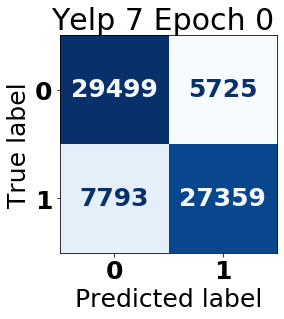

  0%|          | 0/2200 [00:00<?, ?it/s]

Load data/yelp_7_pro128BCE/bert.model.checkpoint1.params ...
Start on [prediction] ...


100%|██████████| 2200/2200 [03:29<00:00, 10.50it/s]


Time for [prediction]: 0:03:29.493469
Confusion Matrix:
[[29301  5923]
 [ 6903 28249]]

CM: [29301  5923  6903 28249] 
[tn, fp, fn, tp]
  accuracy: 0.818
 precision: 0.818
    recall: 0.818
  f1-score: 0.818

Accuracy:  0.818 

Report for [BERTClassifier - yelp_7_pro128BCE]:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82     35224
           1       0.83      0.80      0.81     35152

    accuracy                           0.82     70376
   macro avg       0.82      0.82      0.82     70376
weighted avg       0.82      0.82      0.82     70376



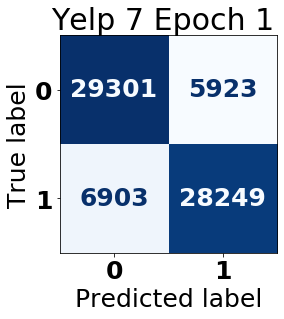

  0%|          | 0/2200 [00:00<?, ?it/s]

Load data/yelp_7_pro128BCE/bert.model.checkpoint2.params ...
Start on [prediction] ...


100%|██████████| 2200/2200 [03:30<00:00, 10.47it/s]


Time for [prediction]: 0:03:30.103111
Confusion Matrix:
[[29567  5657]
 [ 7004 28148]]

CM: [29567  5657  7004 28148] 
[tn, fp, fn, tp]
  accuracy: 0.820
 precision: 0.821
    recall: 0.820
  f1-score: 0.820

Accuracy:  0.82 

Report for [BERTClassifier - yelp_7_pro128BCE]:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82     35224
           1       0.83      0.80      0.82     35152

    accuracy                           0.82     70376
   macro avg       0.82      0.82      0.82     70376
weighted avg       0.82      0.82      0.82     70376



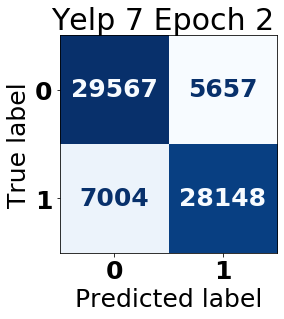

In [40]:
print("Evaluate trained model for each epoch ...")
for epoch_id in range(num_epochs):
    fn_model_state = fn_run_path / f"bert.model.checkpoint{epoch_id}.params"
    print(f"Load {fn_model_state} ...")
    model.load_parameters(str(fn_model_state), ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    with open(fn_run_path / f"eval_epoch{epoch_id}.p", "wb") as fp:
        pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp 7 Epoch {epoch_id}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()

### Load other categories and evaluate

In [46]:
epoch_id = num_epochs - 1
fn_model_state = fn_run_path / f"bert.model.checkpoint{epoch_id}.params"
print(f"Load {fn_model_state} ...")
model.load_parameters(str(fn_model_state), ctx=ctx)

Load data/yelp_7_pro128BCE/bert.model.checkpoint2.params ...


In [45]:
# lst_root_categories
root_categories = get_root_category_items(map_categories)
root_categories = sorted(root_categories, key=lambda x: x["title"])
root_category_labels = [x["title"] for x in root_categories]

Work on Active Life ...
No businesses found for * -> return unchanged


  3%|▎         | 28/1075 [00:00<00:03, 272.96it/s]

#ss (pos) 4300
#ss (neg) 4300


100%|██████████| 1075/1075 [00:03<00:00, 331.23it/s]


#nss 8600
#~ss 17200
review pairs: 17200


  0%|          | 1/538 [00:00<01:08,  7.87it/s]

Start on [prediction] ...


100%|██████████| 538/538 [00:52<00:00, 10.30it/s]


Time for [prediction]: 0:00:52.235280
Confusion Matrix:
[[7225 1375]
 [1766 6834]]

CM: [7225 1375 1766 6834] 
[tn, fp, fn, tp]
  accuracy: 0.817
 precision: 0.818
    recall: 0.817
  f1-score: 0.817

Accuracy:  0.817 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Active Life]:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      8600
           1       0.83      0.79      0.81      8600

    accuracy                           0.82     17200
   macro avg       0.82      0.82      0.82     17200
weighted avg       0.82      0.82      0.82     17200



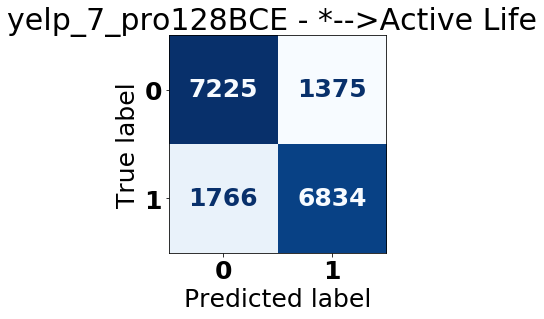

Work on Arts & Entertainment ...
No businesses found for * -> return unchanged


  0%|          | 6/1540 [00:00<00:25, 59.74it/s]

#ss (pos) 6160
#ss (neg) 6160


100%|██████████| 1540/1540 [00:04<00:00, 313.76it/s]


#nss 12320
#~ss 24640
review pairs: 24640


  0%|          | 1/770 [00:00<01:28,  8.70it/s]

Start on [prediction] ...


100%|██████████| 770/770 [01:15<00:00, 10.23it/s]


Time for [prediction]: 0:01:15.258487
Confusion Matrix:
[[9946 2374]
 [3056 9264]]

CM: [9946 2374 3056 9264] 
[tn, fp, fn, tp]
  accuracy: 0.780
 precision: 0.780
    recall: 0.780
  f1-score: 0.779

Accuracy:  0.78 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Arts & Entertainment]:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79     12320
           1       0.80      0.75      0.77     12320

    accuracy                           0.78     24640
   macro avg       0.78      0.78      0.78     24640
weighted avg       0.78      0.78      0.78     24640



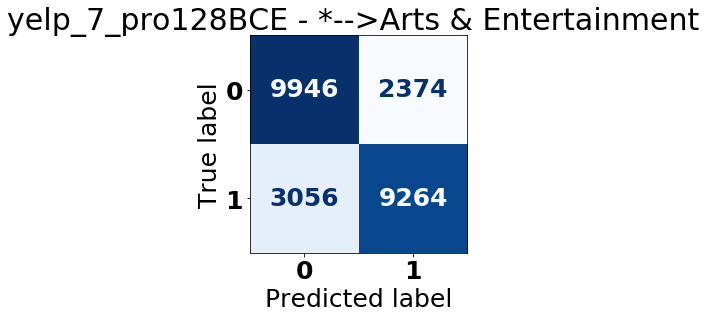

Work on Automotive ...
No businesses found for * -> return unchanged


  2%|▏         | 25/1438 [00:00<00:05, 244.25it/s]

#ss (pos) 5752
#ss (neg) 5752


100%|██████████| 1438/1438 [00:04<00:00, 324.07it/s]


#nss 11504
#~ss 23008
review pairs: 23008


  0%|          | 1/719 [00:00<01:19,  8.99it/s]

Start on [prediction] ...


100%|██████████| 719/719 [01:10<00:00, 10.24it/s]


Time for [prediction]: 0:01:10.244011
Confusion Matrix:
[[10329  1175]
 [ 1412 10092]]

CM: [10329  1175  1412 10092] 
[tn, fp, fn, tp]
  accuracy: 0.888
 precision: 0.888
    recall: 0.888
  f1-score: 0.888

Accuracy:  0.888 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Automotive]:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     11504
           1       0.90      0.88      0.89     11504

    accuracy                           0.89     23008
   macro avg       0.89      0.89      0.89     23008
weighted avg       0.89      0.89      0.89     23008



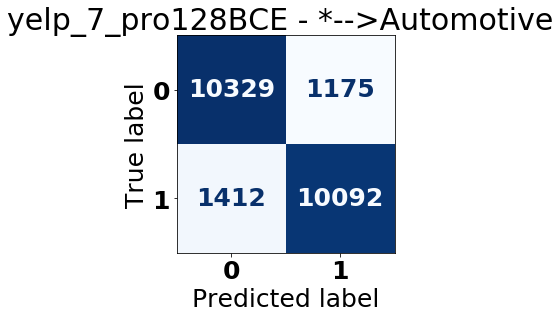

Work on Beauty & Spas ...
No businesses found for * -> return unchanged


  1%|          | 17/2520 [00:00<00:14, 167.28it/s]

#ss (pos) 10080
#ss (neg) 10080


100%|██████████| 2520/2520 [00:07<00:00, 320.16it/s]


#nss 20160
#~ss 40320
review pairs: 40320


  0%|          | 1/1260 [00:00<02:40,  7.82it/s]

Start on [prediction] ...


100%|██████████| 1260/1260 [02:02<00:00, 10.33it/s]


Time for [prediction]: 0:02:02.010266
Confusion Matrix:
[[18317  1843]
 [ 2306 17854]]

CM: [18317  1843  2306 17854] 
[tn, fp, fn, tp]
  accuracy: 0.897
 precision: 0.897
    recall: 0.897
  f1-score: 0.897

Accuracy:  0.897 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Beauty & Spas]:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     20160
           1       0.91      0.89      0.90     20160

    accuracy                           0.90     40320
   macro avg       0.90      0.90      0.90     40320
weighted avg       0.90      0.90      0.90     40320



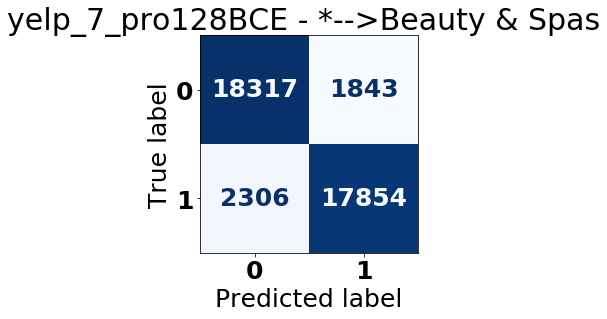

0it [00:00, ?it/s]
0it [00:00, ?it/s]

Work on Bicycles ...
No businesses found for * -> return unchanged
#ss (pos) 0
#ss (neg) 0
#nss 0
#~ss 0
review pairs: 0


KeyError: "['argument2', 'argument1'] not in index"

In [47]:
results_cross_no_overlap = dict()

for root_category_label in root_category_labels:
    if root_category_label == category_name:
        continue

    print(f"Work on {root_category_label} ...")
    # without overlap
    df_other = filter_root_category_businesses_not_other(root_category_label, category_name, inv_cat_bids, map_categories, map_cat_name2id)
    if df_other.shape[0] == 0: continue

    df_other = filter_min_review_freq(df_other, min_ratings=10)
    df_other = filter_both_good_bad(df_other)
    if df_other.shape[0] == 0: continue
    df_other = make_or_load_pairs(df_other, None, num_pairs_per_class=4)
    print("review pairs:", len(df_other))
    
    df_other["tag"] = "NA"
    
    X_dev, y_dev = df_other[names_columns_X_arteval], df_other[names_columns_y]
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {category_name}-->{root_category_label}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} - {category_name}-->{root_category_label}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()
    
    res_one = (len(df_other), len(df_other))
    res_one += compute_metrics(y_true, y_pred, precision=8, averaging="macro", dump=False)
    results_cross_no_overlap[root_category_label] = res_one

Work on Active Life ...


  3%|▎         | 27/1075 [00:00<00:03, 262.19it/s]

#ss (pos) 4300
#ss (neg) 4300


100%|██████████| 1075/1075 [00:03<00:00, 325.12it/s]


#nss 8600
#~ss 17200
review pairs: 17200


  0%|          | 1/538 [00:00<01:08,  7.81it/s]

Start on [prediction] ...


100%|██████████| 538/538 [00:52<00:00, 10.30it/s]


Time for [prediction]: 0:00:52.238225
Confusion Matrix:
[[7161 1439]
 [1726 6874]]

CM: [7161 1439 1726 6874] 
[tn, fp, fn, tp]
  accuracy: 0.816
 precision: 0.816
    recall: 0.816
  f1-score: 0.816

Accuracy:  0.816 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Active Life]:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      8600
           1       0.83      0.80      0.81      8600

    accuracy                           0.82     17200
   macro avg       0.82      0.82      0.82     17200
weighted avg       0.82      0.82      0.82     17200



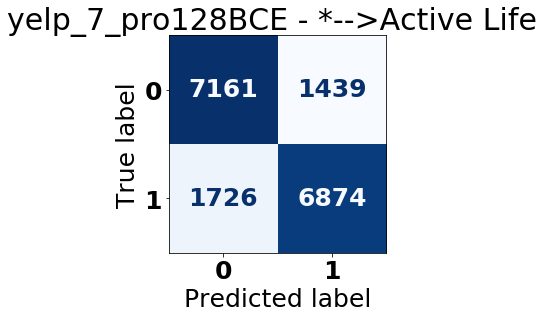

Work on Arts & Entertainment ...


  0%|          | 6/1540 [00:00<00:25, 59.94it/s]

#ss (pos) 6160
#ss (neg) 6160


100%|██████████| 1540/1540 [00:04<00:00, 314.18it/s]


#nss 12320
#~ss 24640
review pairs: 24640


  0%|          | 1/770 [00:00<01:26,  8.89it/s]

Start on [prediction] ...


100%|██████████| 770/770 [01:15<00:00, 10.24it/s]


Time for [prediction]: 0:01:15.214658
Confusion Matrix:
[[9917 2403]
 [3044 9276]]

CM: [9917 2403 3044 9276] 
[tn, fp, fn, tp]
  accuracy: 0.779
 precision: 0.780
    recall: 0.779
  f1-score: 0.779

Accuracy:  0.779 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Arts & Entertainment]:
              precision    recall  f1-score   support

           0       0.77      0.80      0.78     12320
           1       0.79      0.75      0.77     12320

    accuracy                           0.78     24640
   macro avg       0.78      0.78      0.78     24640
weighted avg       0.78      0.78      0.78     24640



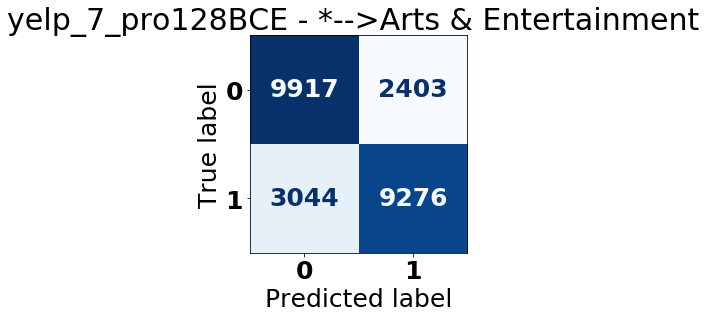

Work on Automotive ...


  2%|▏         | 25/1438 [00:00<00:05, 248.92it/s]

#ss (pos) 5752
#ss (neg) 5752


100%|██████████| 1438/1438 [00:04<00:00, 331.41it/s]


#nss 11504
#~ss 23008
review pairs: 23008


  0%|          | 1/719 [00:00<01:21,  8.78it/s]

Start on [prediction] ...


100%|██████████| 719/719 [01:10<00:00, 10.23it/s]


Time for [prediction]: 0:01:10.296860
Confusion Matrix:
[[10329  1175]
 [ 1436 10068]]

CM: [10329  1175  1436 10068] 
[tn, fp, fn, tp]
  accuracy: 0.887
 precision: 0.887
    recall: 0.887
  f1-score: 0.887

Accuracy:  0.887 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Automotive]:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     11504
           1       0.90      0.88      0.89     11504

    accuracy                           0.89     23008
   macro avg       0.89      0.89      0.89     23008
weighted avg       0.89      0.89      0.89     23008



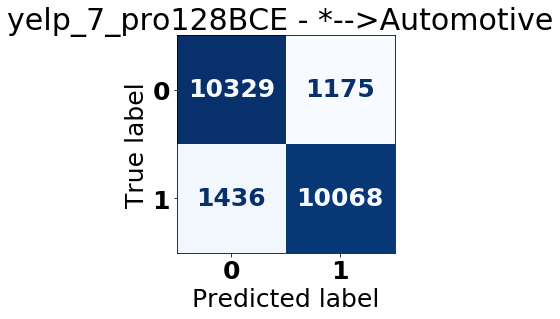

Work on Beauty & Spas ...


  1%|          | 17/2520 [00:00<00:14, 167.75it/s]

#ss (pos) 10080
#ss (neg) 10080


100%|██████████| 2520/2520 [00:07<00:00, 330.74it/s]


#nss 20160
#~ss 40320
review pairs: 40320


  0%|          | 1/1260 [00:00<02:39,  7.89it/s]

Start on [prediction] ...


100%|██████████| 1260/1260 [02:02<00:00, 10.32it/s]


Time for [prediction]: 0:02:02.053301
Confusion Matrix:
[[18242  1918]
 [ 2338 17822]]

CM: [18242  1918  2338 17822] 
[tn, fp, fn, tp]
  accuracy: 0.894
 precision: 0.895
    recall: 0.894
  f1-score: 0.894

Accuracy:  0.894 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Beauty & Spas]:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90     20160
           1       0.90      0.88      0.89     20160

    accuracy                           0.89     40320
   macro avg       0.89      0.89      0.89     40320
weighted avg       0.89      0.89      0.89     40320



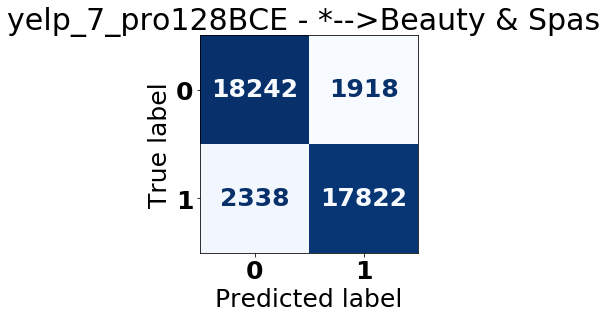

Work on Bicycles ...
Work on Education ...


 20%|█▉        | 33/168 [00:00<00:00, 324.31it/s]

#ss (pos) 672
#ss (neg) 672


100%|██████████| 168/168 [00:00<00:00, 326.41it/s]


#nss 1344
#~ss 2688
review pairs: 2688


  1%|          | 1/84 [00:00<00:09,  8.67it/s]

Start on [prediction] ...


100%|██████████| 84/84 [00:08<00:00,  9.84it/s]

Time for [prediction]: 0:00:08.535172
Confusion Matrix:
[[1129  215]
 [ 250 1094]]

CM: [1129  215  250 1094] 
[tn, fp, fn, tp]
  accuracy: 0.827
 precision: 0.827
    recall: 0.827
  f1-score: 0.827

Accuracy:  0.827 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Education]:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1344
           1       0.84      0.81      0.82      1344

    accuracy                           0.83      2688
   macro avg       0.83      0.83      0.83      2688
weighted avg       0.83      0.83      0.83      2688



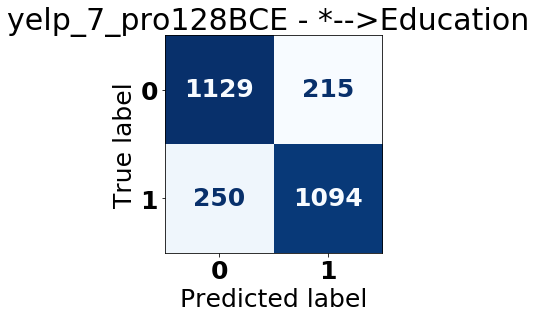

Work on Event Planning & Services ...


  0%|          | 0/2409 [00:00<?, ?it/s]

#ss (pos) 9636
#ss (neg) 9636


100%|██████████| 2409/2409 [00:07<00:00, 324.40it/s]


#nss 19272
#~ss 38544
review pairs: 38544


  0%|          | 1/1205 [00:00<02:27,  8.14it/s]

Start on [prediction] ...


100%|██████████| 1205/1205 [01:58<00:00, 10.17it/s]


Time for [prediction]: 0:01:58.502614
Confusion Matrix:
[[16015  3257]
 [ 3983 15289]]

CM: [16015  3257  3983 15289] 
[tn, fp, fn, tp]
  accuracy: 0.812
 precision: 0.813
    recall: 0.812
  f1-score: 0.812

Accuracy:  0.812 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Event Planning & Services]:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82     19272
           1       0.82      0.79      0.81     19272

    accuracy                           0.81     38544
   macro avg       0.81      0.81      0.81     38544
weighted avg       0.81      0.81      0.81     38544



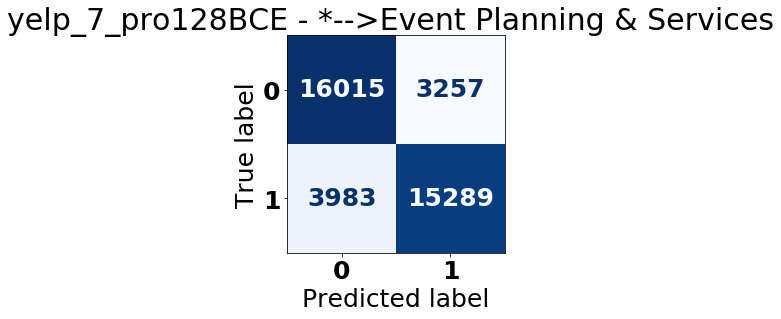

  0%|          | 0/82 [00:00<?, ?it/s]

Work on Financial Services ...


 40%|████      | 33/82 [00:00<00:00, 325.42it/s]

#ss (pos) 328
#ss (neg) 328


  0%|          | 0/41 [00:00<?, ?it/s]

#nss 656
#~ss 1312
review pairs: 1312
Start on [prediction] ...


100%|██████████| 41/41 [00:03<00:00, 10.32it/s]


Time for [prediction]: 0:00:03.975042
Confusion Matrix:
[[610  46]
 [ 77 579]]

CM: [610  46  77 579] 
[tn, fp, fn, tp]
  accuracy: 0.906
 precision: 0.907
    recall: 0.906
  f1-score: 0.906

Accuracy:  0.906 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Financial Services]:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       656
           1       0.93      0.88      0.90       656

    accuracy                           0.91      1312
   macro avg       0.91      0.91      0.91      1312
weighted avg       0.91      0.91      0.91      1312



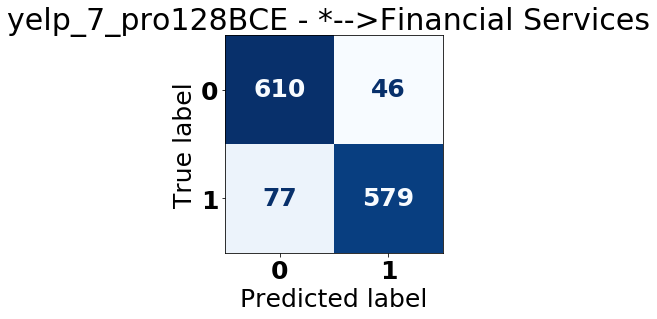

Work on Food ...


100%|██████████| 8171/8171 [00:26<00:00, 311.37it/s]


#ss (pos) 32684
#ss (neg) 32684


100%|██████████| 8171/8171 [00:25<00:00, 318.53it/s]


#nss 65368
#~ss 130736
review pairs: 130736


  0%|          | 1/4086 [00:00<08:13,  8.27it/s]

Start on [prediction] ...


100%|██████████| 4086/4086 [06:30<00:00, 10.46it/s]


Time for [prediction]: 0:06:30.457605
Confusion Matrix:
[[54461 10907]
 [13856 51512]]

CM: [54461 10907 13856 51512] 
[tn, fp, fn, tp]
  accuracy: 0.811
 precision: 0.811
    recall: 0.811
  f1-score: 0.810

Accuracy:  0.811 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Food]:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81     65368
           1       0.83      0.79      0.81     65368

    accuracy                           0.81    130736
   macro avg       0.81      0.81      0.81    130736
weighted avg       0.81      0.81      0.81    130736



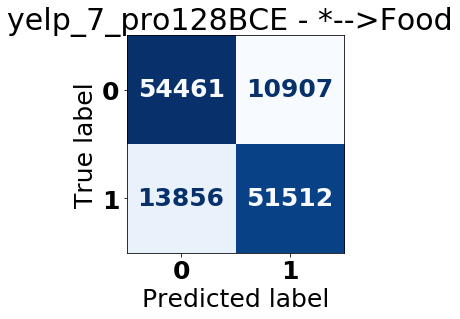

Work on Health & Medical ...


  2%|▏         | 29/1368 [00:00<00:04, 282.18it/s]

#ss (pos) 5472
#ss (neg) 5472


100%|██████████| 1368/1368 [00:04<00:00, 323.13it/s]


#nss 10944
#~ss 21888
review pairs: 21888


  0%|          | 1/684 [00:00<01:37,  7.00it/s]

Start on [prediction] ...


100%|██████████| 684/684 [01:07<00:00, 10.10it/s]


Time for [prediction]: 0:01:07.709067
Confusion Matrix:
[[9929 1015]
 [1188 9756]]

CM: [9929 1015 1188 9756] 
[tn, fp, fn, tp]
  accuracy: 0.899
 precision: 0.899
    recall: 0.899
  f1-score: 0.899

Accuracy:  0.899 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Health & Medical]:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     10944
           1       0.91      0.89      0.90     10944

    accuracy                           0.90     21888
   macro avg       0.90      0.90      0.90     21888
weighted avg       0.90      0.90      0.90     21888



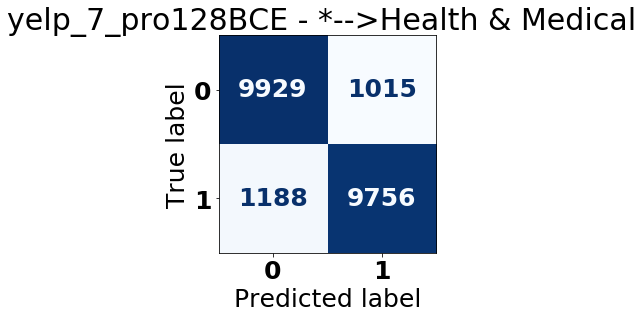

Work on Home Services ...


  2%|▏         | 30/1212 [00:00<00:04, 295.46it/s]

#ss (pos) 4848
#ss (neg) 4848


100%|██████████| 1212/1212 [00:03<00:00, 331.10it/s]


#nss 9696
#~ss 19392
review pairs: 19392


  0%|          | 1/606 [00:00<01:10,  8.60it/s]

Start on [prediction] ...


100%|██████████| 606/606 [01:01<00:00,  9.93it/s]


Time for [prediction]: 0:01:01.059150
Confusion Matrix:
[[8812  884]
 [1094 8602]]

CM: [8812  884 1094 8602] 
[tn, fp, fn, tp]
  accuracy: 0.898
 precision: 0.898
    recall: 0.898
  f1-score: 0.898

Accuracy:  0.898 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Home Services]:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      9696
           1       0.91      0.89      0.90      9696

    accuracy                           0.90     19392
   macro avg       0.90      0.90      0.90     19392
weighted avg       0.90      0.90      0.90     19392



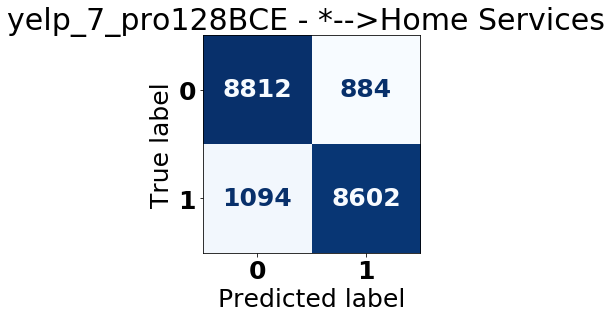

Work on Hotels & Travel ...


  1%|▏         | 20/1357 [00:00<00:06, 198.52it/s]

#ss (pos) 5428
#ss (neg) 5428


100%|██████████| 1357/1357 [00:04<00:00, 320.55it/s]


#nss 10856
#~ss 21712
review pairs: 21712


  0%|          | 1/679 [00:00<01:16,  8.90it/s]

Start on [prediction] ...


100%|██████████| 679/679 [01:07<00:00,  9.99it/s]


Time for [prediction]: 0:01:07.963981
Confusion Matrix:
[[9074 1782]
 [2208 8648]]

CM: [9074 1782 2208 8648] 
[tn, fp, fn, tp]
  accuracy: 0.816
 precision: 0.817
    recall: 0.816
  f1-score: 0.816

Accuracy:  0.816 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Hotels & Travel]:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82     10856
           1       0.83      0.80      0.81     10856

    accuracy                           0.82     21712
   macro avg       0.82      0.82      0.82     21712
weighted avg       0.82      0.82      0.82     21712



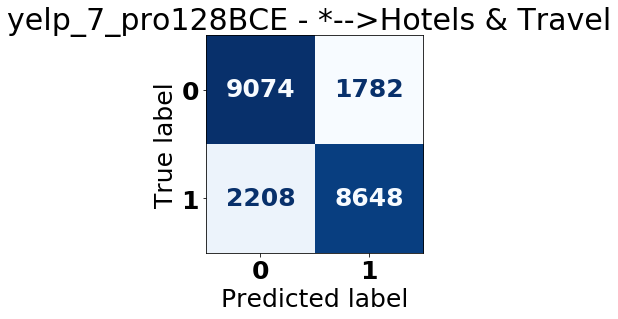

Work on Local Flavor ...


  9%|▉         | 31/341 [00:00<00:01, 301.87it/s]

#ss (pos) 1364
#ss (neg) 1364


100%|██████████| 341/341 [00:01<00:00, 326.82it/s]


#nss 2728
#~ss 5456
review pairs: 5456


  1%|          | 1/171 [00:00<00:18,  9.33it/s]

Start on [prediction] ...


100%|██████████| 171/171 [00:16<00:00, 10.22it/s]

Time for [prediction]: 0:00:16.742741
Confusion Matrix:
[[2241  487]
 [ 644 2084]]

CM: [2241  487  644 2084] 
[tn, fp, fn, tp]
  accuracy: 0.793
 precision: 0.794
    recall: 0.793
  f1-score: 0.793

Accuracy:  0.793 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Local Flavor]:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      2728
           1       0.81      0.76      0.79      2728

    accuracy                           0.79      5456
   macro avg       0.79      0.79      0.79      5456
weighted avg       0.79      0.79      0.79      5456



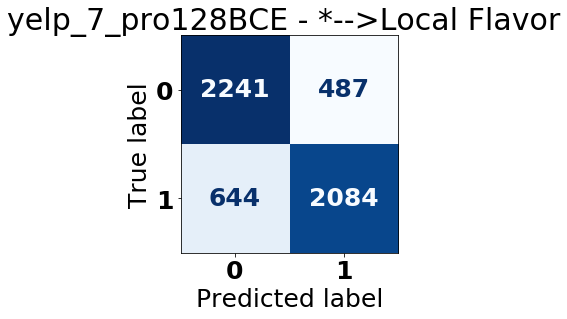

Work on Local Services ...


  4%|▎         | 31/871 [00:00<00:02, 304.49it/s]

#ss (pos) 3484
#ss (neg) 3484


100%|██████████| 871/871 [00:02<00:00, 331.62it/s]


#nss 6968
#~ss 13936
review pairs: 13936


  0%|          | 1/436 [00:00<00:47,  9.12it/s]

Start on [prediction] ...


100%|██████████| 436/436 [00:42<00:00, 10.27it/s]


Time for [prediction]: 0:00:42.458899
Confusion Matrix:
[[6247  721]
 [ 884 6084]]

CM: [6247  721  884 6084] 
[tn, fp, fn, tp]
  accuracy: 0.885
 precision: 0.885
    recall: 0.885
  f1-score: 0.885

Accuracy:  0.885 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Local Services]:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      6968
           1       0.89      0.87      0.88      6968

    accuracy                           0.88     13936
   macro avg       0.89      0.88      0.88     13936
weighted avg       0.89      0.88      0.88     13936



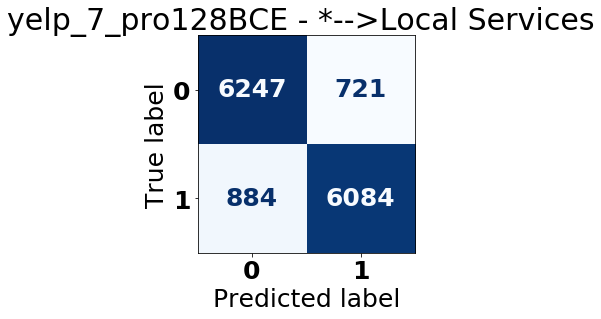

Work on Mass Media ...


  0%|          | 0/6 [00:00<?, ?it/s]

#ss (pos) 44
#ss (neg) 44
#nss 88
#~ss 176
review pairs: 176
Start on [prediction] ...


100%|██████████| 6/6 [00:00<00:00, 10.84it/s]


Time for [prediction]: 0:00:00.554983
Confusion Matrix:
[[79  9]
 [16 72]]

CM: [79  9 16 72] 
[tn, fp, fn, tp]
  accuracy: 0.858
 precision: 0.860
    recall: 0.858
  f1-score: 0.858

Accuracy:  0.858 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Mass Media]:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        88
           1       0.89      0.82      0.85        88

    accuracy                           0.86       176
   macro avg       0.86      0.86      0.86       176
weighted avg       0.86      0.86      0.86       176



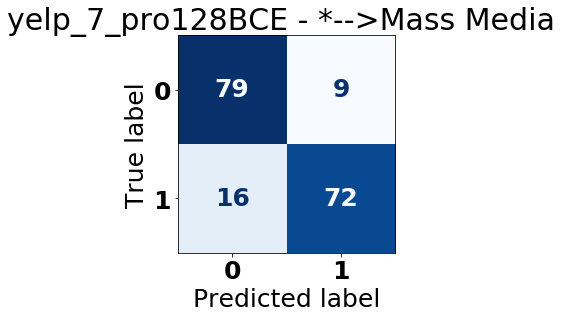

Work on Nightlife ...


100%|██████████| 6126/6126 [00:19<00:00, 309.47it/s]


#ss (pos) 24504
#ss (neg) 24504


100%|██████████| 6126/6126 [00:19<00:00, 315.41it/s]


#nss 49008
#~ss 98016
review pairs: 98016


  0%|          | 1/3063 [00:00<06:21,  8.02it/s]

Start on [prediction] ...


100%|██████████| 3063/3063 [04:56<00:00, 10.33it/s]


Time for [prediction]: 0:04:56.622580
Confusion Matrix:
[[40227  8781]
 [10917 38091]]

CM: [40227  8781 10917 38091] 
[tn, fp, fn, tp]
  accuracy: 0.799
 precision: 0.800
    recall: 0.799
  f1-score: 0.799

Accuracy:  0.799 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Nightlife]:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80     49008
           1       0.81      0.78      0.79     49008

    accuracy                           0.80     98016
   macro avg       0.80      0.80      0.80     98016
weighted avg       0.80      0.80      0.80     98016



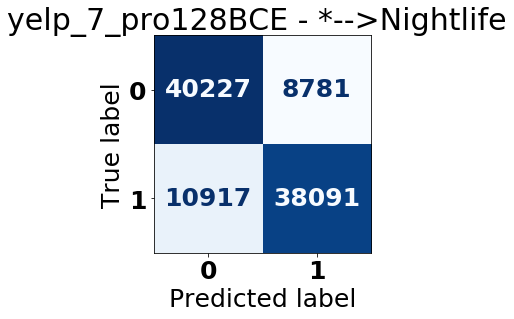

Work on Pets ...


  7%|▋         | 33/478 [00:00<00:01, 322.26it/s]

#ss (pos) 1912
#ss (neg) 1912


100%|██████████| 478/478 [00:01<00:00, 334.96it/s]


#nss 3824
#~ss 7648
review pairs: 7648


  0%|          | 1/239 [00:00<00:29,  8.06it/s]

Start on [prediction] ...


100%|██████████| 239/239 [00:24<00:00,  9.92it/s]


Time for [prediction]: 0:00:24.098861
Confusion Matrix:
[[3430  394]
 [ 469 3355]]

CM: [3430  394  469 3355] 
[tn, fp, fn, tp]
  accuracy: 0.887
 precision: 0.887
    recall: 0.887
  f1-score: 0.887

Accuracy:  0.887 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Pets]:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      3824
           1       0.89      0.88      0.89      3824

    accuracy                           0.89      7648
   macro avg       0.89      0.89      0.89      7648
weighted avg       0.89      0.89      0.89      7648



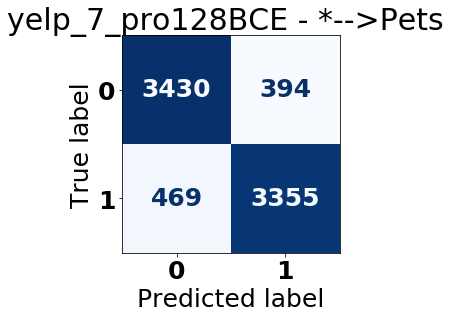

Work on Professional Services ...


 12%|█▏        | 33/278 [00:00<00:00, 323.08it/s]

#ss (pos) 1112
#ss (neg) 1112


100%|██████████| 278/278 [00:00<00:00, 328.53it/s]


#nss 2224
#~ss 4448
review pairs: 4448


  1%|          | 1/139 [00:00<00:14,  9.33it/s]

Start on [prediction] ...


100%|██████████| 139/139 [00:13<00:00, 10.26it/s]


Time for [prediction]: 0:00:13.554153
Confusion Matrix:
[[2003  221]
 [ 257 1967]]

CM: [2003  221  257 1967] 
[tn, fp, fn, tp]
  accuracy: 0.893
 precision: 0.893
    recall: 0.893
  f1-score: 0.893

Accuracy:  0.893 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Professional Services]:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2224
           1       0.90      0.88      0.89      2224

    accuracy                           0.89      4448
   macro avg       0.89      0.89      0.89      4448
weighted avg       0.89      0.89      0.89      4448



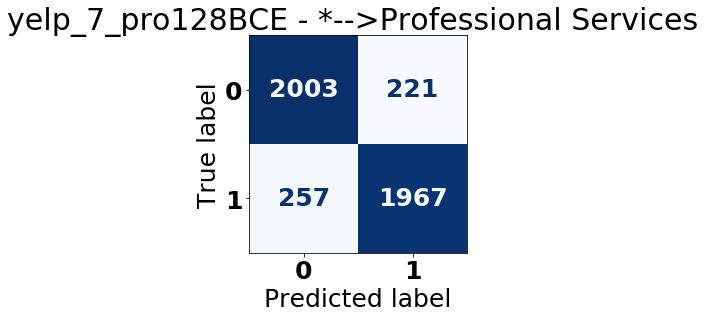

Work on Public Services & Government ...


 26%|██▌       | 33/128 [00:00<00:00, 324.13it/s]

#ss (pos) 512
#ss (neg) 512


  0%|          | 0/64 [00:00<?, ?it/s]

#nss 1024
#~ss 2048
review pairs: 2048
Start on [prediction] ...


100%|██████████| 64/64 [00:06<00:00, 10.33it/s]


Time for [prediction]: 0:00:06.200132
Confusion Matrix:
[[829 195]
 [250 774]]

CM: [829 195 250 774] 
[tn, fp, fn, tp]
  accuracy: 0.783
 precision: 0.784
    recall: 0.783
  f1-score: 0.783

Accuracy:  0.783 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Public Services & Government]:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1024
           1       0.80      0.76      0.78      1024

    accuracy                           0.78      2048
   macro avg       0.78      0.78      0.78      2048
weighted avg       0.78      0.78      0.78      2048



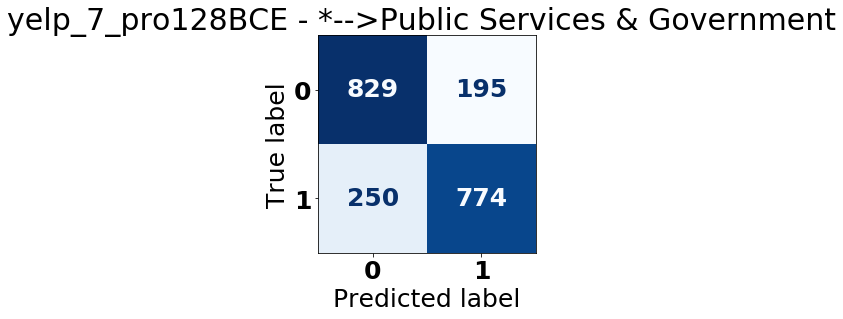

100%|██████████| 16/16 [00:00<00:00, 319.73it/s]

Work on Religious Organizations ...



  0%|          | 0/8 [00:00<?, ?it/s]

#ss (pos) 64
#ss (neg) 64
#nss 128
#~ss 256
review pairs: 256
Start on [prediction] ...


100%|██████████| 8/8 [00:00<00:00, 10.00it/s]

Time for [prediction]: 0:00:00.801444
Confusion Matrix:
[[101  27]
 [ 24 104]]

CM: [101  27  24 104] 
[tn, fp, fn, tp]
  accuracy: 0.801
 precision: 0.801
    recall: 0.801
  f1-score: 0.801

Accuracy:  0.801 

Report for [BERTClassifier - yelp_7_pro128BCE - *-->Religious Organizations]:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       128
           1       0.79      0.81      0.80       128

    accuracy                           0.80       256
   macro avg       0.80      0.80      0.80       256
weighted avg       0.80      0.80      0.80       256



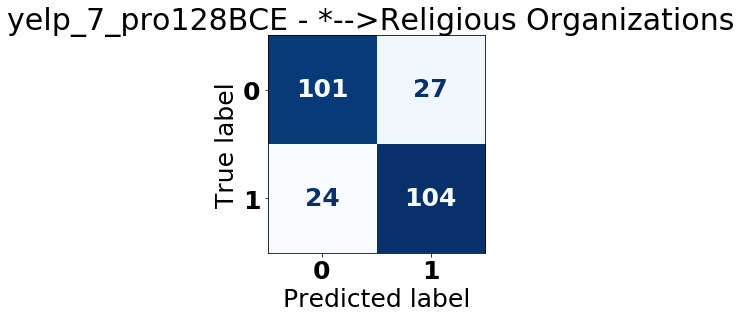

Work on Restaurants ...


100%|██████████| 23491/23491 [01:16<00:00, 306.52it/s]


#ss (pos) 93964
#ss (neg) 93964


100%|██████████| 23491/23491 [01:15<00:00, 312.03it/s]


#nss 187928
#~ss 375856
review pairs: 375856


  0%|          | 1/11746 [00:00<23:38,  8.28it/s]

Start on [prediction] ...


 55%|█████▍    | 6413/11746 [10:15<08:32, 10.41it/s]

In [ ]:
results_cross_overlap = dict()

for root_category_label in root_category_labels:
    if root_category_label == category_name:
        continue

    print(f"Work on {root_category_label} ...")
    # with overlap
    df_other = load_cached_root_category_businesses_df(root_category_label, map_categories)
    if df_other.shape[0] == 0: continue

    df_other = filter_min_review_freq(df_other, min_ratings=10)
    df_other = filter_both_good_bad(df_other)
    if df_other.shape[0] == 0: continue
    # TODO: maybe reset randomness here, so previous calls to random don't influence it?
    df_other = make_or_load_pairs(df_other, None, num_pairs_per_class=4)
    print("review pairs:", len(df_other))
    
    df_other["tag"] = "NA"
    
    X_dev, y_dev = df_other[names_columns_X_arteval], df_other[names_columns_y]
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size)
    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {category_name}-->{root_category_label}", heatmap=False)
    plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"{run_name} - {category_name}-->{root_category_label}", values_format="d", cmap="Blues", include_colorbar=False)
    plt.show()
    
    res_one = (len(df_other), len(df_other))
    res_one += compute_metrics(y_true, y_pred, precision=8, averaging="macro", dump=False)
    results_cross_overlap[root_category_label] = res_one

In [ ]:
results_cross_no_overlap

In [61]:
results_cross_overlap

{'Active Life': (17200,
  17200,
  0.8163406796300763,
  0.8159883720930232,
  0.8159371245437113,
  0.8159883720930232,
  array([[7161, 1439],
         [1726, 6874]])),
 'Arts & Entertainment': (24640,
  24640,
  0.7796938306472303,
  0.7789366883116883,
  0.7787869801986445,
  0.7789366883116883,
  array([[9917, 2403],
         [3044, 9276]])),
 'Automotive': (23008,
  23008,
  0.886716789431505,
  0.8865177329624478,
  0.8865031277738114,
  0.8865177329624478,
  array([[10329,  1175],
         [ 1436, 10068]])),
 'Beauty & Spas': (40320,
  40320,
  0.8946157186278767,
  0.8944444444444444,
  0.8944329896907217,
  0.8944444444444445,
  array([[18242,  1918],
         [ 2338, 17822]])),
 'Education': (2688,
  2688,
  0.82723084619173,
  0.8270089285714286,
  0.826979594328388,
  0.8270089285714286,
  array([[1129,  215],
         [ 250, 1094]])),
 'Event Planning & Services': (38544,
  38544,
  0.8126063496029319,
  0.8121627231216273,
  0.8120960584773335,
  0.8121627231216272,
  arr

In [ ]:
print(f"""{"Category":<30}: {"Prec":<7} {"Rec":<7} {"F1":<7} {"Acc":<7} -- Confusion (tn, fp, fn, tp)""")

for name, (num_business, num_pairs, prec, rec, f1, acc, cm) in results_cross_no_overlap.items():
    print(f"{name:<30}: {prec * 100:5.2f}%  {rec * 100:5.2f}%  {f1 * 100:5.2f}%  {acc * 100:5.2f}%  -- {cm.flatten().tolist()}")

In [62]:
print(f"""{"Category":<30}: {"Prec":<7} {"Rec":<7} {"F1":<7} {"Acc":<7} -- Confusion (tn, fp, fn, tp)""")

for name, (num_business, num_pairs, prec, rec, f1, acc, cm) in results_cross_overlap.items():
    print(f"{name:<30}: {prec * 100:5.2f}%  {rec * 100:5.2f}%  {f1 * 100:5.2f}%  {acc * 100:5.2f}%  -- {cm.flatten().tolist()}")

Category                      : Prec    Rec     F1      Acc     -- Confusion (tn, fp, fn, tp)
Active Life                   : 81.63%  81.60%  81.59%  81.60%  -- [7161, 1439, 1726, 6874]
Arts & Entertainment          : 77.97%  77.89%  77.88%  77.89%  -- [9917, 2403, 3044, 9276]
Automotive                    : 88.67%  88.65%  88.65%  88.65%  -- [10329, 1175, 1436, 10068]
Beauty & Spas                 : 89.46%  89.44%  89.44%  89.44%  -- [18242, 1918, 2338, 17822]
Education                     : 82.72%  82.70%  82.70%  82.70%  -- [1129, 215, 250, 1094]
Event Planning & Services     : 81.26%  81.22%  81.21%  81.22%  -- [16015, 3257, 3983, 15289]
Financial Services            : 90.72%  90.62%  90.62%  90.62%  -- [610, 46, 77, 579]
Food                          : 81.12%  81.06%  81.05%  81.06%  -- [54461, 10907, 13856, 51512]
Health & Medical              : 89.95%  89.94%  89.93%  89.94%  -- [9929, 1015, 1188, 9756]
Home Services                 : 89.82%  89.80%  89.80%  89.80%  -- [8812, 88

In [64]:
fn_results = fn_run_path / "results_cross_dicts.p"

with open(fn_results, "wb") as fp:
    pickle.dump((category_name, "overlap", results_cross_overlap), fp, protocol=pickle.HIGHEST_PROTOCOL)
    # below may not have made sense (because we trained on all data, so there should be overlap?)
    #                                         results_cross_no_overlap
    pickle.dump((category_name, "no overlap", None), fp, protocol=pickle.HIGHEST_PROTOCOL)